
## Experimental Setup

We first define key parameters used throughout the analysis:

- `dur = 40`: the length of each trial in time bins.  
- `emb_dim = 3`: dimensionality of the latent embedding space (NER aims to reduce neural activity into 3D).  
- `N_angles = 8`: number of possible movement directions in the reaching task.  
- `batch_size = 512`: batch size used for training the embedding model.  
- `directory`: path to the dataset location in Google Drive.

In [ ]:
dur = 40
emb_dim = 3
N_angles = 8
batch_size = 512
directory = '/content/drive/MyDrive/University/Principles of Cognitive Science/NeuroAI/'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig_width, fig_height = plt.rcParams['figure.figsize']

## Data Preparation

**Loading Neural and Behavioral Data**

The dataset comes from monkey reaching experiments recorded with a Utah electrode array implanted in the primary motor cortex (M1).

- `neural`: spike activity from M1 neurons.  
- `velocity`: continuous hand velocities (scaled).  
- `direction`: discrete reaching directions (angles).  

In [ ]:
import scipy.io as sio

mat_contents = sio.loadmat(directory + 'NER/data_NER/Fig1/Chewie_20161014_neural_con_dis_index.mat')

neural = mat_contents['neural_M1']
velocity = mat_contents['continuous_index'] * 10
direction = mat_contents['discrete_index'].ravel()

**Visualizing Hand Velocity**

We plot the first few time bins of X and Y velocity.  
This gives us an intuition of the movement patterns the monkey performed during the session.

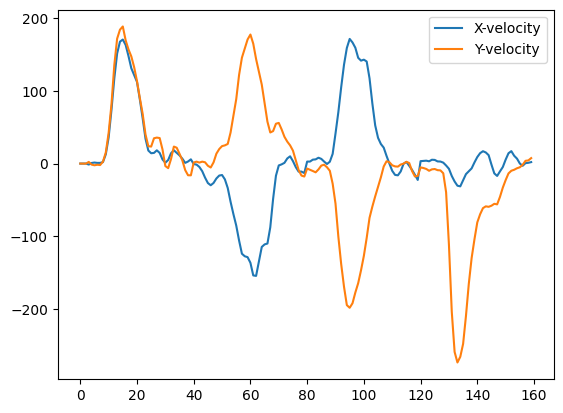

In [ ]:
value_range = dur * 4

plt.plot(velocity[:value_range, 0], label='X-velocity')
plt.plot(velocity[:value_range, 1], label='Y-velocity')
plt.legend()
plt.show()

**Preprocessing Direction Labels**

The raw direction angles are mapped into new values (multiples of 45°) to standardize them across eight bins.  
This step ensures consistent labeling of reaching directions in the analysis.

In [ ]:
angle_to_new_value = {-180: 4,-135: 5,-90: 6,-45: 7,0: 0,45: 1,90: 2,135: 3,180: 4}
vectorized_map = np.vectorize(lambda x: angle_to_new_value[x] * 45)
direction = vectorized_map(direction)

**Splitting into Training and Test Sets**

We divide the data into training and test sets:

- **80%** of trials are used for training.  
- **20%** of trials are reserved for testing.  

Both neural activity and behavioral variables (velocity, direction) are split accordingly.

In [ ]:
N_bins, N_neurons = neural.shape

total_trial = int(N_bins / dur)
train_trial = int(total_trial * 0.8)
split_idx = train_trial * dur

neural_train = neural[:split_idx]
neural_test = neural[split_idx:]
vel_train = velocity[:split_idx]
vel_test = velocity[split_idx:]
dir_train = direction[:split_idx]
dir_test = direction[split_idx:]

**Preparing Combined Datasets**

For convenience, we concatenate velocity and direction into a single array:  

- `veldir_train`: contains training velocities and directions.  
- `veldir_test`: contains test velocities and directions.  

These combined arrays will later be used as targets for learning the neural embeddings.

In [ ]:
veldir_train = np.hstack((vel_train, dir_train.reshape(-1, 1)))
veldir_test = np.hstack((vel_test, dir_test.reshape(-1, 1)))

## Utility Functions

Before applying different embedding models, we define a set of helper functions.  
These utilities handle visualization, decoding, and evaluation in a consistent way across all methods.

**Loss Plotting**

`plot_loss()` visualizes the training (and optional validation) loss.  
It also reports the average loss over the last 10 iterations, helping us monitor convergence.

In [ ]:
def plot_loss(loss, val_loss=None):
    plt.plot(loss, label='Train Loss')

    if val_loss is not None:
        plt.plot(val_loss, label='Validation Loss')
        plt.title(f'Final train = {np.mean(loss[-10:]):.4f} | Final val = {np.mean(val_loss[-10:]):.4f}')
    else:
        plt.title(f'Final loss = {np.mean(loss[-10:]):.4f}')
    plt.xlabel('Iterations')
    plt.ylabel('RnC Loss')
    plt.legend()
    plt.show()

**Position Reconstruction**

`calculate_locations()` integrates the velocity across time bins to reconstruct hand positions.  
This allows us to compare predicted versus actual movement trajectories.

In [ ]:
def calculate_locations(velocity):
    velocity_reshaped = velocity.reshape(-1, dur, 2)
    position = np.cumsum(velocity_reshaped, axis=1)
    return position.reshape(-1, 2)

**Embedding Visualization**

`plot_embedding()` creates 3D scatter plots of the learned embeddings:

- **Left panel**: raw embeddings colored by movement direction.  
- **Right panel**: trial-averaged embeddings per direction, showing the trajectory structure.  

In [ ]:
def plot_embedding(embedding, direction):
    plt.figure(figsize=(2 * fig_width, fig_height), dpi=200)

    ax1 = plt.subplot(1, 2, 1, projection='3d')
    ax1.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=direction / 360, cmap=plt.cm.hsv, edgecolors='none', s=0.5)
    ax1.set_axis_off()

    ax2 = plt.subplot(1, 2, 2, projection='3d')
    for i in range(N_angles):
        direction_trial = (direction // 45 == i)
        trial_avg = embedding[direction_trial, :].reshape(-1, dur, emb_dim).mean(axis=0)

        ax2.scatter(trial_avg[:, 0], trial_avg[:, 1], trial_avg[:, 2], color=plt.cm.hsv(1 / 8 * i), s=3)
        ax2.plot(trial_avg[:, 0], trial_avg[:, 1], trial_avg[:, 2], color=plt.cm.hsv(1 / 8 * i), linewidth=0.5)

    ax2.set_axis_off()
    plt.show()

**Decoding Movements**

The `decode()` function trains simple linear models on the embeddings:  

- **Linear Regression** → predicts continuous velocities.  
- **Logistic Regression** → predicts discrete movement directions.  

This provides a direct way to evaluate how well the embeddings align with behavior.

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression

def decode(embedding_train, embedding_test, vel_train, dir_train):
    LinReg = LinearRegression()
    LinReg.fit(embedding_train, vel_train)
    vel_pred = LinReg.predict(embedding_test)

    LogisticReg = LogisticRegression(max_iter=10000, solver='lbfgs')
    LogisticReg.fit(embedding_train, dir_train)
    dir_pred = LogisticReg.predict(embedding_test)

    return vel_pred, dir_pred

**Position and Velocity Evaluation**

- `plot_position()` compares true versus predicted hand positions and reports the R² score.  
- `decode_velocity()` predicts X- and Y-velocities separately using linear regression.  
- `plot_velocity()` visualizes predicted versus actual velocities, again with R² values.  

In [ ]:
from sklearn.metrics import r2_score

def plot_position(pos_true, pos_pred, dir_true, dir_pred):
    plt.figure(figsize=(2 * fig_width, fig_height))

    plt.subplot(1, 2, 1)
    plt.scatter(pos_true[:, 0], pos_true[:, 1], alpha=1, color=plt.cm.hsv(1 / 360 * dir_true), s=0.3)
    plt.gca().set_aspect('equal')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.scatter(pos_pred[:, 0], pos_pred[:, 1], alpha=1, color=plt.cm.hsv(1 / 360 * dir_pred), s=0.3)
    plt.gca().set_aspect('equal')
    plt.axis('off')

    plt.suptitle(f'True vs Pred - R2 pos = {r2_score(pos_true, pos_pred):.3f}')
    plt.show()

In [ ]:
def decode_velocity(embedding_train, embedding_test, vel_train):
    model_x = LinearRegression()
    model_x.fit(embedding_train, vel_train[:, 0])
    vel_pred_x = model_x.predict(embedding_test)

    model_y = LinearRegression()
    model_y.fit(embedding_train, vel_train[:, 1])
    vel_pred_y = model_y.predict(embedding_test)

    return vel_pred_x, vel_pred_y

In [ ]:
def plot_velocity(vel_test, vel_pred):
    plt.figure(figsize=(2 * fig_width, fig_height))

    plt.subplot(1, 2, 1)
    plt.scatter(vel_test[:, 0], vel_pred[:, 0], s=0.1)
    plt.plot(vel_test[:, 0], vel_test[:, 0])
    plt.title(f'Actual vs Predicted X-velocity - R-squared: {r2_score(vel_test[:, 0], vel_pred[:, 0]):.2f}')
    plt.xlabel('Actual X-velocity')
    plt.ylabel('Predicted X-velocity')

    plt.subplot(1, 2, 2)
    plt.scatter(vel_test[:, 1], vel_pred[:, 1], s=0.1)
    plt.plot(vel_test[:, 1], vel_test[:, 1])
    plt.title(f'Actual vs Predicted Y-velocity - R-squared: {r2_score(vel_test[:, 1], vel_pred[:, 1]):.2f}')
    plt.xlabel('Actual Y-velocity')
    plt.ylabel('Predicted Y-velocity')

    plt.show()

## Neural Embeddings Rank (NER)

The key contribution of the paper is the **NER method**, which learns low-dimensional neural embeddings aligned with continuous movements.  
NER is inspired by contrastive learning (like CEBRA) but introduces a new **ranking-based loss** that better handles continuous labels and class imbalance.

**Motivation**

- Traditional contrastive methods (e.g., CEBRA) treat each label as a **discrete class**.  
- This works poorly when labels are continuous (e.g., velocity, position) or highly imbalanced (many near-zero velocities).  
- NER instead **orders embeddings by their labels**, ensuring that embeddings respect the relative distances of movement variables.

**Label Difference**

The `LabelDifference` class computes pairwise distances between labels.  

- Trial indices (`X`, `Y`) capture temporal proximity.  
- Movement direction is compared **circularly**, so that angles wrap around (e.g., 0° and 315° differ by 45°).  
- The total label distance combines index differences and angular differences.  

This ensures that embeddings are ranked according to meaningful behavioral differences.

```
class LabelDifference(nn.Module):
    def __init__(self, distance_type='l1'):
        super(LabelDifference, self).__init__()
        self.distance_type = distance_type

    def forward(self, labels):
        # labels: [bs, label_dim]
        # output: [bs, bs]
        if self.distance_type == 'l1':
            indices_X = labels[:, 0] ## [bs]
            indices_Y = labels[:, 1]
            angles = labels[:, 2] ## [bs]
            index_diffs_X = torch.abs(indices_X[:, None] - indices_X[None, :]) ## [bs, bs]
            index_diffs_Y = torch.abs(indices_Y[:, None] - indices_Y[None, :])
            index_diffs = index_diffs_X + index_diffs_Y

            angle_diffs = torch.abs(angles[:, None] - angles[None, :]) ## enough for Hippo but no harm with next step
            circular_angle_diffs = torch.min(angle_diffs, 360 - angle_diffs) ## [bs, bs]; make sure distance of (0, 270/315) is 90/45degree

            total_L1_distances = index_diffs+circular_angle_diffs ## [bs, bs]    
            return total_L1_distances
        
        else:
            raise ValueError(self.distance_type)
```

**Feature Similarity**

The `FeatureSimilarity` class computes pairwise similarity between embeddings.  

- By default, it uses negative L2 distance.  
- The negative sign means that **closer embeddings get higher similarity scores**.  

This similarity matrix is later contrasted against label distances.

```
class FeatureSimilarity(nn.Module):
    def __init__(self, similarity_type='l2'):
        super(FeatureSimilarity, self).__init__()
        self.similarity_type = similarity_type

    def forward(self, features):
        # labels: [bs, feat_dim]
        # output: [bs, bs]
        if self.similarity_type == 'l2':
            return - (features[:, None, :] - features[None, :, :]).norm(2, dim=-1) ## notice negative sign "-1"
        else:
            raise ValueError(self.similarity_type)
```

**NER Loss Function**

NER modifies the contrastive loss by **ranking embeddings** instead of classifying them.  

Let:  
- $ v_i $: the embedding of anchor sample $ i $.  
- $ y_i $: its label (movement variables).  
- $ \text{sim}(v_i, v_j) $: similarity between embeddings.  
- $ d(y_i, y_j) $: label distance.  

The NER loss for anchor $ i $ is:

$$
\ell_i^{\text{NER}} = \frac{1}{2N - 1} \sum_{j \neq i} - \log \frac{\exp\big(\text{sim}(v_i, v_j) / \tau\big)}{\sum\limits_{k \in S_{i,j}} \exp\big(\text{sim}(v_i, v_k) / \tau\big)}
$$

where  
- $ S_{i,j} = \{ v_k \,|\, d(y_i, y_k) \geq d(y_i, y_j) \} $ is the set of embeddings with **lower rank (larger label distance)** than $ v_j $.  
- $ \tau $ is the temperature parameter controlling sharpness.

Intuition:
- For each anchor $ v_i $, all other embeddings $ v_j $ are **ranked by label distance**.  
- If two samples are behaviorally close (small label distance), their embeddings are encouraged to be **more similar**.  
- If they are far apart, the embeddings should be **less similar**.  

Thus, embeddings form a **continuous, ordered space** aligned with movements.

```
class NERLoss(nn.Module):
    def __init__(self, temperature = 1 , label_diff='l1', feature_sim='l2'):
        super(NERLoss, self).__init__()
        self.t = temperature
        self.label_diff_fn = LabelDifference(label_diff)
        self.feature_sim_fn = FeatureSimilarity(feature_sim)

    def forward(self, features, labels):
        # input features: [bs, 2, 1/2/3feat_dim]
        # input labels: [bs, 1/2/3label_dim]
        
        features = torch.cat([features[:, 0], features[:, 1]], dim=0)  # change from [bs, 2, feat_dim] to [2bs, feat_dim]
        labels = labels.repeat(2, 1)  # change from [bs, label_dim] to [2bs, label_dim] must be 2times repeat because we only have "ref" & "pos"

        label_diffs = self.label_diff_fn(labels) ##[bs, label_dim]
            ## divide similarity score by temperature, >1larger==smoother
        logits = self.feature_sim_fn(features).div(self.t) ##[bs, feat_dim]
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits -= logits_max.detach()
        exp_logits = logits.exp()

        n = logits.shape[0]  # n = 2bs

        # remove diagonal
        logits = logits.masked_select((1 - torch.eye(n).to(logits.device)).bool()).view(n, n - 1)
        exp_logits = exp_logits.masked_select((1 - torch.eye(n).to(logits.device)).bool()).view(n, n - 1)
        label_diffs = label_diffs.masked_select((1 - torch.eye(n).to(logits.device)).bool()).view(n, n - 1)

        loss = 0.
        for k in range(n - 1):
            pos_logits = logits[:, k]  # 2bs
            pos_label_diffs = label_diffs[:, k]  # 2bs
            neg_mask = (label_diffs >= pos_label_diffs.view(-1, 1)).float()  # [2bs, 2bs - 1]
            pos_log_probs = pos_logits - torch.log((neg_mask * exp_logits).sum(dim=-1))  # 2bs
            loss += - (pos_log_probs / (n * (n - 1))).sum()
        return loss
```

In [ ]:
pip install scikit-learn==1.5.2 literate-dataclasses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 91.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [ ]:
%%sh
git clone https://github.com/NeuroscienceAI/NER.git
mv NER/NER_Code_1021 NER/cebra

Cloning into 'NER'...
Updating files: 100% (1196/1196), done.


In [ ]:
import sys
sys.path.insert(0, '/content/NER')

**Training NER**

We train NER using the same architecture as CEBRA but replace the loss with `NERLoss`.  
Key settings:
- Batch size: 512  
- Learning rate: 0.0001
- Embedding dimension: 3  
- Temperature: 1  
- Iterations: 5000  

After training, embeddings are computed for both train and test sessions.

In [ ]:
from cebra import CEBRA

ner_model = CEBRA(
    model_architecture='offset1-model',
    batch_size=batch_size,
    learning_rate=0.0001,
    temperature=1,
    output_dimension=emb_dim,
    max_iterations=5000,
    conditional='time_delta',
    device="cuda", ### 'cuda_if_available'
    verbose=True,
    time_offsets=1
)

emb_ner_train = ner_model.fit_transform(neural_train, veldir_train)
emb_ner_test = ner_model.transform(neural_test)

pos: -0.9379 neg:  6.7800 total:  5.6625 temperature:  1.0000: 100%|██████████| 5000/5000 [38:25<00:00,  2.17it/s]


1. **Loss Curve**  
   The loss decreases smoothly, confirming stable training.  

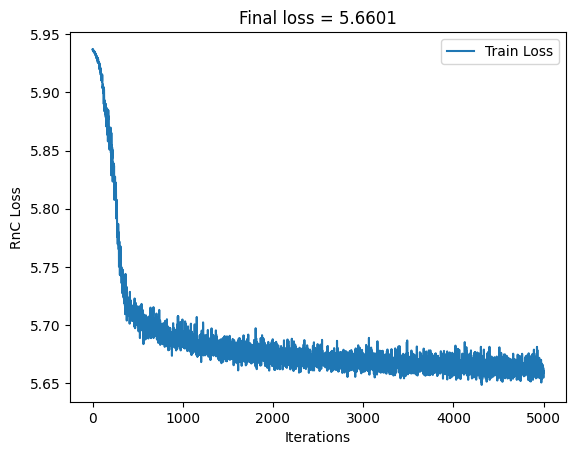

In [ ]:
plot_loss(ner_model.state_dict_['loss'].numpy())

2. **Embedding Visualization**  
   The 3D embeddings align clearly with the eight movement directions.  
   - Trial-averaged trajectories form a **pinwheel-like structure**.  
   - Each trajectory corresponds to one reaching direction.

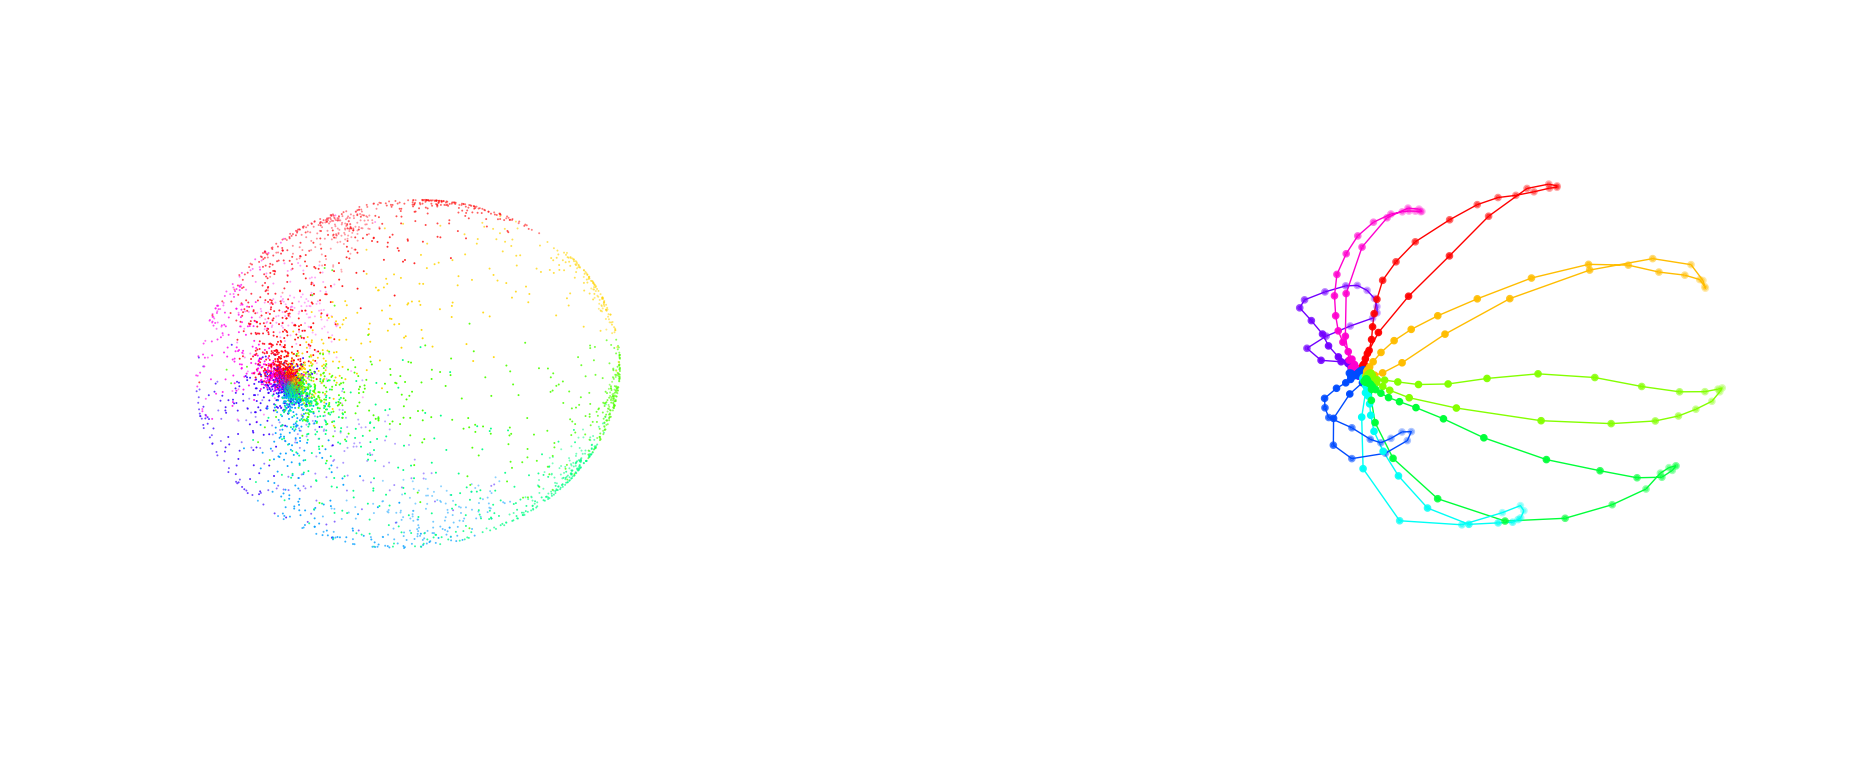

In [ ]:
plot_embedding(emb_ner_test, dir_test)

3. **Velocity Decoding**  
   Linear regression on embeddings explains most of the variance in hand velocities.  

4. **Direction Classification**  
   Logistic regression accurately predicts movement directions from embeddings.

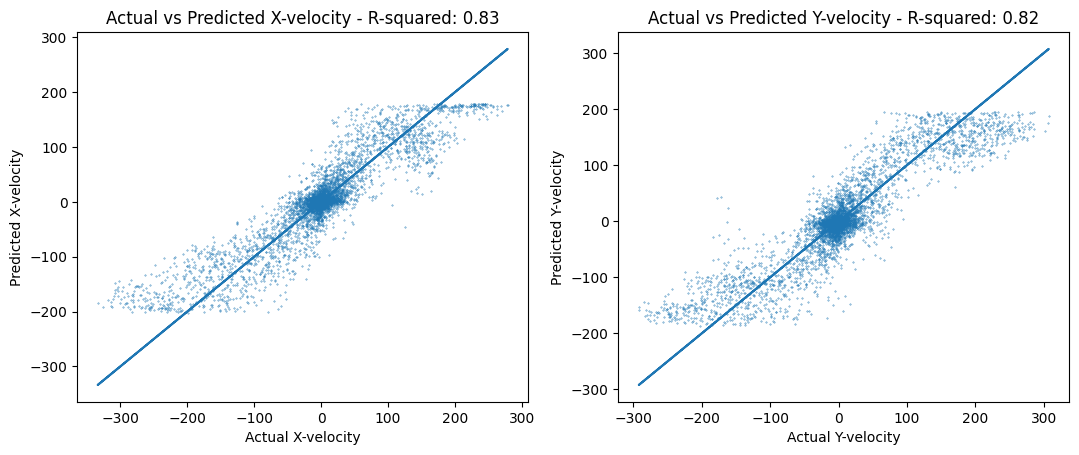

In [ ]:
vel_pred, dir_pred = decode(emb_ner_train, emb_ner_test, vel_train, dir_train)

plot_velocity(vel_test, vel_pred)

5. **Position Reconstruction**  
   Integrating predicted velocities reconstructs movement trajectories that closely match the ground truth.  

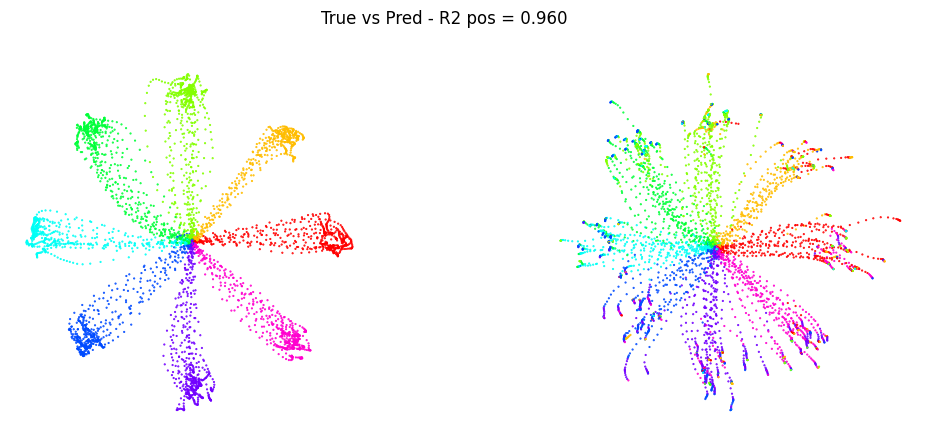

In [ ]:
pos_test = calculate_locations(vel_test)
pos_pred = calculate_locations(vel_pred)

plot_position(pos_test, pos_pred, dir_test, dir_pred)

## CEBRA

Next, we implement **CEBRA** (Contrastive Embedding for Behavior and neural Representation Analysis).  
CEBRA is a contrastive learning framework that learns neural embeddings by treating each sample (or time point) as a separate class.


**CEBRA Loss Function**

For each anchor embedding $ v_i $, CEBRA selects:  
- A positive sample $ v_j $ (with similar label, e.g., close in time).  
- Several negative samples $ v_n $ (with different labels).  

The loss is:

$$
\ell_i^{\text{CEBRA}} = - \log \frac{\exp(\text{sim}(v_i, v_j)/\tau)}{\sum_{n=1}^N \exp(\text{sim}(v_i, v_n)/\tau)}
$$

where  
- $ \text{sim}(\cdot, \cdot) $ is similarity (e.g., negative L2 distance).  
- $ \tau $ is the temperature.  

This encourages embeddings of positive pairs to be close, and negative pairs to be far apart.

**Training Setup**

We train CEBRA with the same settings as NER for a fair comparison:
- Embedding dimension: 3  
- Batch size: 512  
- Learning rate: 0.0001  
- Temperature: 1  
- Iterations: 5000  

The only difference is in the **loss function**, where CEBRA uses a standard contrastive objective.

In [ ]:
pip install cebra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.0/205.0 kB 4.0 MB/s eta 0:00:00


In [ ]:
from cebra import CEBRA

cebra_model = CEBRA(
    model_architecture='offset1-model',
    batch_size=batch_size,
    learning_rate=0.0001,
    temperature=1,
    output_dimension=emb_dim,
    max_iterations=5000,
    conditional='time_delta',
    device="cpu", ### 'cuda_if_available'
    verbose=True,
    time_offsets=1
)

emb_cebra_train = cebra_model.fit_transform(neural_train, veldir_train)
emb_cebra_test = cebra_model.transform(neural_test)

pos: -0.8746 neg:  6.4050 total:  5.5304 temperature:  1.0000: 100%|██████████| 5000/5000 [35:44<00:00,  2.33it/s]


1. **Loss Curve**  
   Training converges steadily, similar to NER.

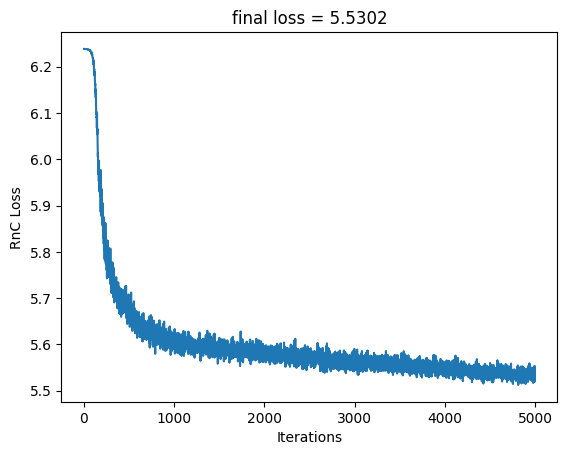

In [ ]:
plot_loss(cebra_model.state_dict_['loss'].numpy())

2. **Embedding Visualization**  
   The 3D embeddings show some separation across movement directions, but the trajectories are often **entangled**.  
   Unlike NER, they do not form clean pinwheel-like structures aligned with behavior.  

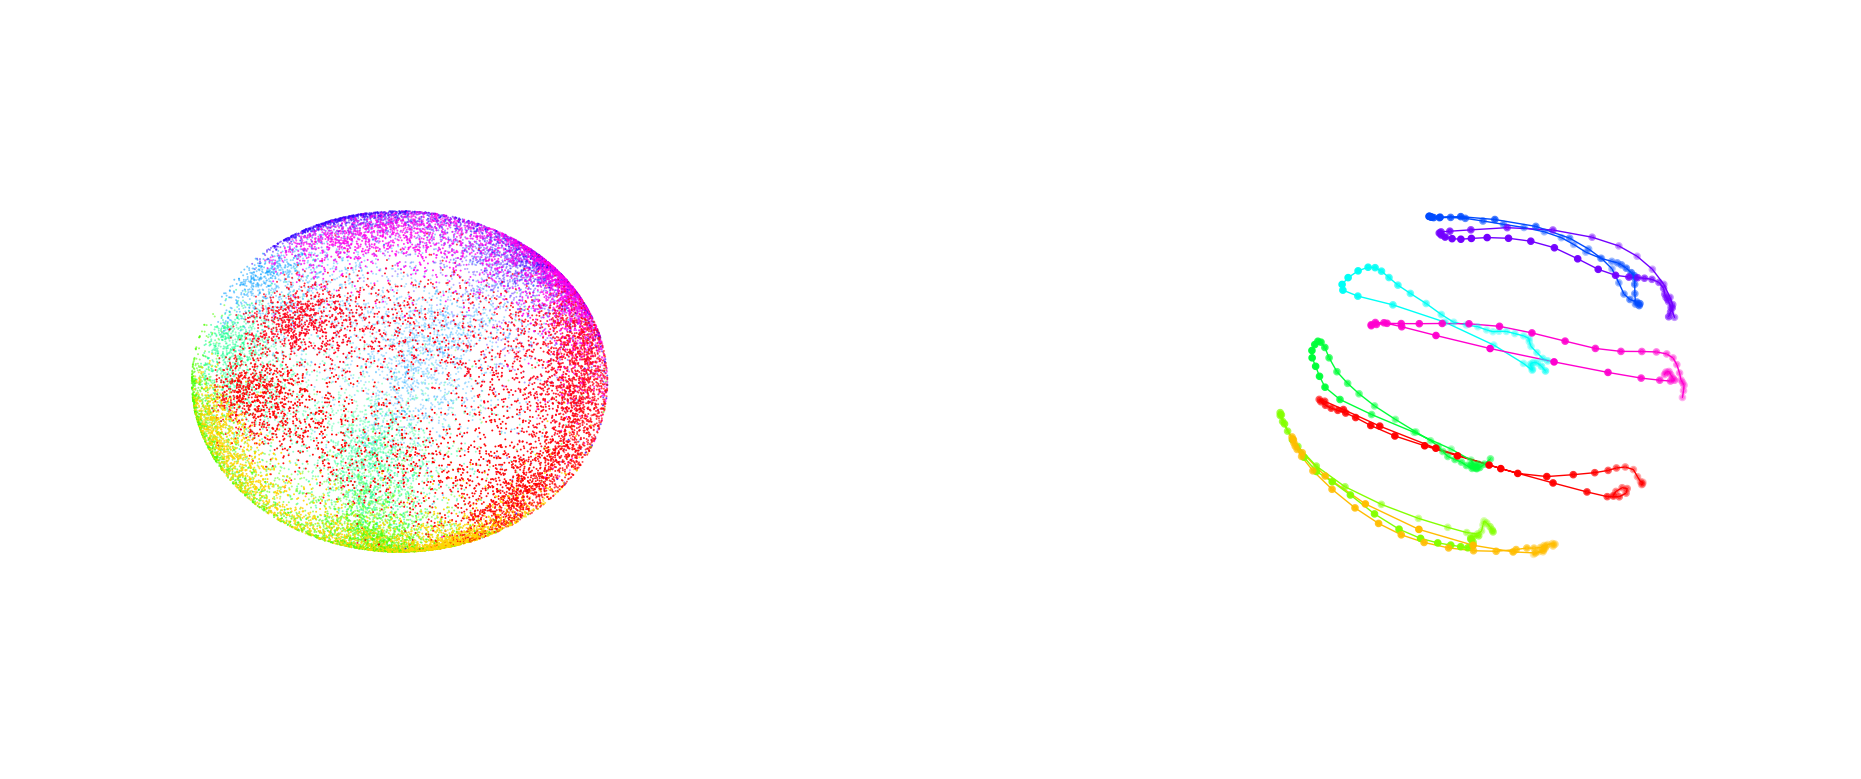

In [ ]:
plot_embedding(emb_cebra_test, dir_test)

3. **Velocity Decoding**  
   Linear regression explains less variance compared to NER.  
   Predictions of large velocities are often biased toward small velocities due to imbalance in the dataset.  

5. **Direction Classification**  
   Logistic regression achieves moderate accuracy, but is less consistent across sessions compared to NER.

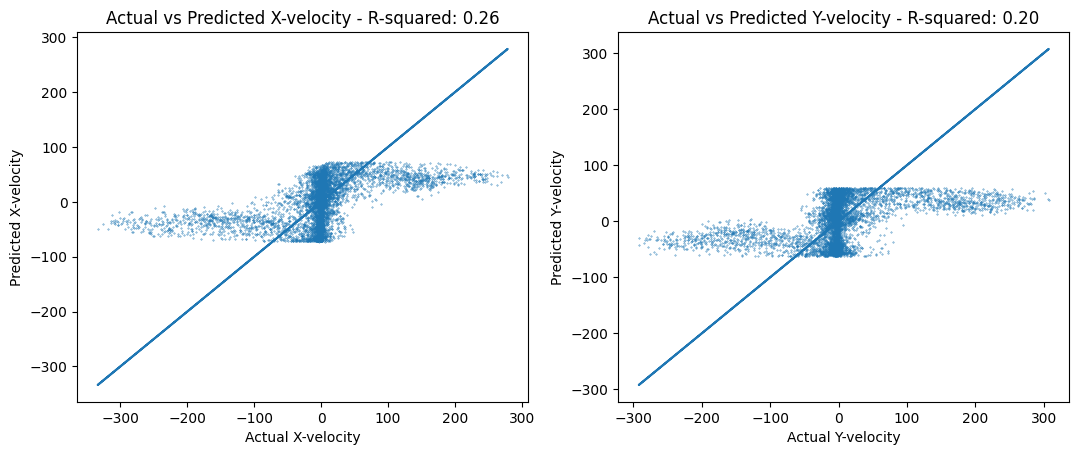

In [ ]:
vel_pred, dir_pred = decode(emb_cebra_train, emb_cebra_test, vel_train, dir_train)

plot_velocity(vel_test, vel_pred)

4. **Position Reconstruction**  
   Reconstructed hand trajectories deviate from the ground truth, especially in high-velocity segments.  

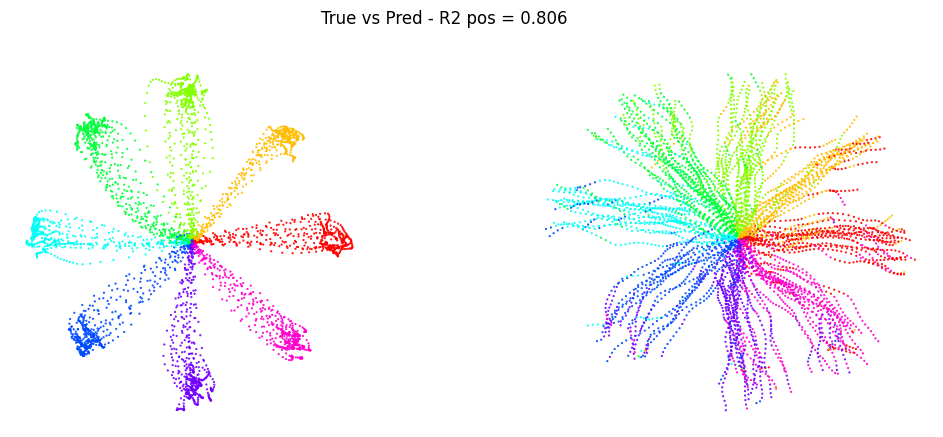

In [ ]:
pos_test = calculate_locations(vel_test)
pos_pred = calculate_locations(vel_pred)

plot_position(pos_test, pos_pred, dir_test, dir_pred)

## pi-VAE

We now apply **pi-VAE** (Poisson-implicit Variational Autoencoder), another method for learning latent neural embeddings.  
Unlike contrastive approaches (NER, CEBRA), pi-VAE is a **generative model** that explicitly accounts for neural spiking statistics.


**Input Preprocessing: Receptive Fields**

The neural activity is reshaped into a 3D tensor using a **temporal receptive field**:

- Each time bin is expanded to include a local window of size 10.  
- This allows the model to capture short-term temporal dependencies in neural firing.  

The function `dataset_2D_to_3D` performs this transformation.

In [ ]:
def dataset_2D_to_3D(dataset_2D):
    # data = train_set.neural.numpy()  # [time_bins, neurons]
    time_bins, neurons = dataset_2D.shape
    receptive_field_size = 10  # Total bins in receptive field
    half_window = receptive_field_size // 2
    dataset_3D = np.zeros((time_bins, neurons, receptive_field_size))
    for t in range(time_bins):
        for n in range(neurons):
            # Calculate the indices for the receptive field window
            start_idx = max(0, t - half_window)
            end_idx = min(time_bins, t + half_window + 1)

            # Slice the window for neuron n
            window = dataset_2D[start_idx:end_idx, n]

            # Calculate where to place the window in the receptive field dimension
            # Adjusting indices to fit exactly within the receptive field slots
            window_start = half_window - (t - start_idx)
            window_end = window_start + (end_idx - start_idx)

            # Ensure the window fits exactly into the new_data array
            window_start = max(0, window_start)
            window_end = min(receptive_field_size, window_end)

            dataset_3D[t, n, window_start:window_end] = window[:window_end - window_start]
    return dataset_3D

neural_train = dataset_2D_to_3D(neural_train)
neural_test = dataset_2D_to_3D(neural_test)

**Batching the Data**

Since pi-VAE expects batched inputs, we split both neural activity and labels into chunks of size 512.  
The helper function `to_batch_list` handles this batching.

In [ ]:
def to_batch_list(x, y, batch_size):
    x = x.squeeze()
    if len(x.shape) == 3:
        x = x.transpose(0,2,1)
    x_batch_list = np.array_split(x, int(len(x) / batch_size))
    y_batch_list = np.array_split(y, int(len(y) / batch_size))
    return x_batch_list, y_batch_list

neural_train, veldir_train = to_batch_list(neural_train, veldir_train, batch_size)
neural_test, veldir_test = to_batch_list(neural_test, veldir_test, batch_size)

**Custom Data Generator**

`custom_data_generator` yields batches of neural activity together with behavioral labels.  
This generator is used to continuously feed the model during training, mimicking standard deep learning data pipelines.

In [ ]:
def custom_data_generator(x_all, u_one_hot):
    while True:
        for i in range(len(x_all)):
            yield ([x_all[i], u_one_hot[i]], None)

train_loader = custom_data_generator(neural_train, veldir_train)
test_loader  = custom_data_generator(neural_test, veldir_test)

**pi-VAE Model**

We define a convolutional pi-VAE model using `conv_vae_mdl`:

- `dim_x = N_neurons`: number of input neurons.  
- `dim_z = 3`: embedding dimension.  
- `dim_u = 3`: label dimension (continuous variables such as velocity).  
- `mdl = "poisson"`: assumes spiking activity follows Poisson statistics.  
- `gen_nodes = 60, n_blk = 2`: size and depth of the generator network.  

The model learns a latent space where neural activity and behavior are jointly represented.

In [ ]:
from pivae_code.conv_pi_vae import conv_vae_mdl

pivae_model = conv_vae_mdl(
    dim_x = N_neurons,  # number of neurons
    dim_z = emb_dim,    # embedding dimension
    dim_u = 3,          # label (discrete or continuous) dimension; Hippo's position+L+R=3
    time_window=10,
    gen_nodes=60,
    n_blk=2,
    mdl="poisson",
    disc=False,
    learning_rate=0.00025
)

2025-08-21 23:16:13.669464: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-08-21 23:16:13.669491: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-08-21 23:16:17.126751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-21 23:16:17.127600: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-08-21 23:16:17.128197: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 88)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 3), (None, 3 31160       input_1[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 10, 88)       1602913     encoder[0][2]                  

/home/reza/miniconda3/envs/ner/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


**Training**

We train the model for 50 epochs with:

- Optimizer learning rate: 0.00025  
- Training data: receptive-field expanded neural activity + behavioral labels  
- Validation data: held-out test set  

The history of training and validation loss provides feedback on convergence.

In [ ]:
history = pivae_model.fit_generator(
    train_loader,
    steps_per_epoch=len(neural_train),
    epochs=50,
    verbose=1,
    validation_data = test_loader,
    validation_steps = len(neural_test)
)

/home/reza/miniconda3/envs/ner/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2025-08-21 23:16:19.824059: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
46/46 [==============================] - 17s 143ms/step - loss: 616.0231 - val_loss: 538.7083
Epoch 2/50
46/46 [==============================] - 6s 126ms/step - loss: 544.4463 - val_loss: 530.1129
Epoch 3/50
46/46 [==============================] - 7s 144ms/step - loss: 540.4045 - val_loss: 527.5901
Epoch 4/50
46/46 [==============================] - 6s 133ms/step - loss: 537.9190 - val_loss: 525.3039
Epoch 5/50
46/46 [==============================] - 6s 137ms/step - loss: 535.9202 - val_loss: 523.6913
Epoch 6/50
46/46 [==============================] - 8s 183ms/step - loss: 534.4867 - val_loss: 522.3091
Epoch 7/50
46/46 [==============================] - 6s 140ms/step - loss: 533.0532 - val_loss: 520.9340
Epoch 8/50
46/46 [==============================] - 6s 122ms/step - loss: 531.8303 - val_loss: 519.8540
Epoch 9/50
46/46 [==============================] - 7s 144ms/step - loss: 530.8035 - val_loss: 518.8829
Epoch 10/50
46/46 [==============================] - 6s 130ms/s

**Extracting Embeddings**

After training:
- We use the trained pi-VAE to extract embeddings for both train and test sets.  
- These embeddings are then used in the same downstream analyses as with NER and CEBRA.

In [ ]:
neural_train = np.concatenate(neural_train)
veldir_train = np.concatenate(veldir_train)
emb_pivae_train = pivae_model.predict([neural_train, veldir_train])[0]

neural_test = np.concatenate(neural_test)
veldir_test = np.concatenate(veldir_test)
emb_pivae_test = pivae_model.predict([neural_test, veldir_test])[0]

2025-08-21 23:21:21.178722: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 83353600 exceeds 10% of free system memory.
2025-08-21 23:21:27.324317: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 83353600 exceeds 10% of free system memory.
2025-08-21 23:21:27.789600: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 20838400 exceeds 10% of free system memory.
2025-08-21 23:21:29.360718: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 20838400 exceeds 10% of free system memory.


1. **Loss Curve**  
   Training and validation loss decrease steadily, showing stable convergence.

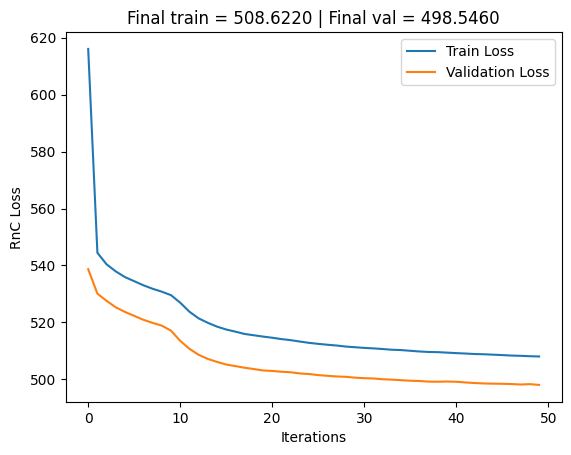

In [ ]:
plot_loss(history.history['loss'], history.history['val_loss'])

2. **Embedding Visualization**  
   The learned embeddings reflect movement directions but appear **less structured** compared to NER.  

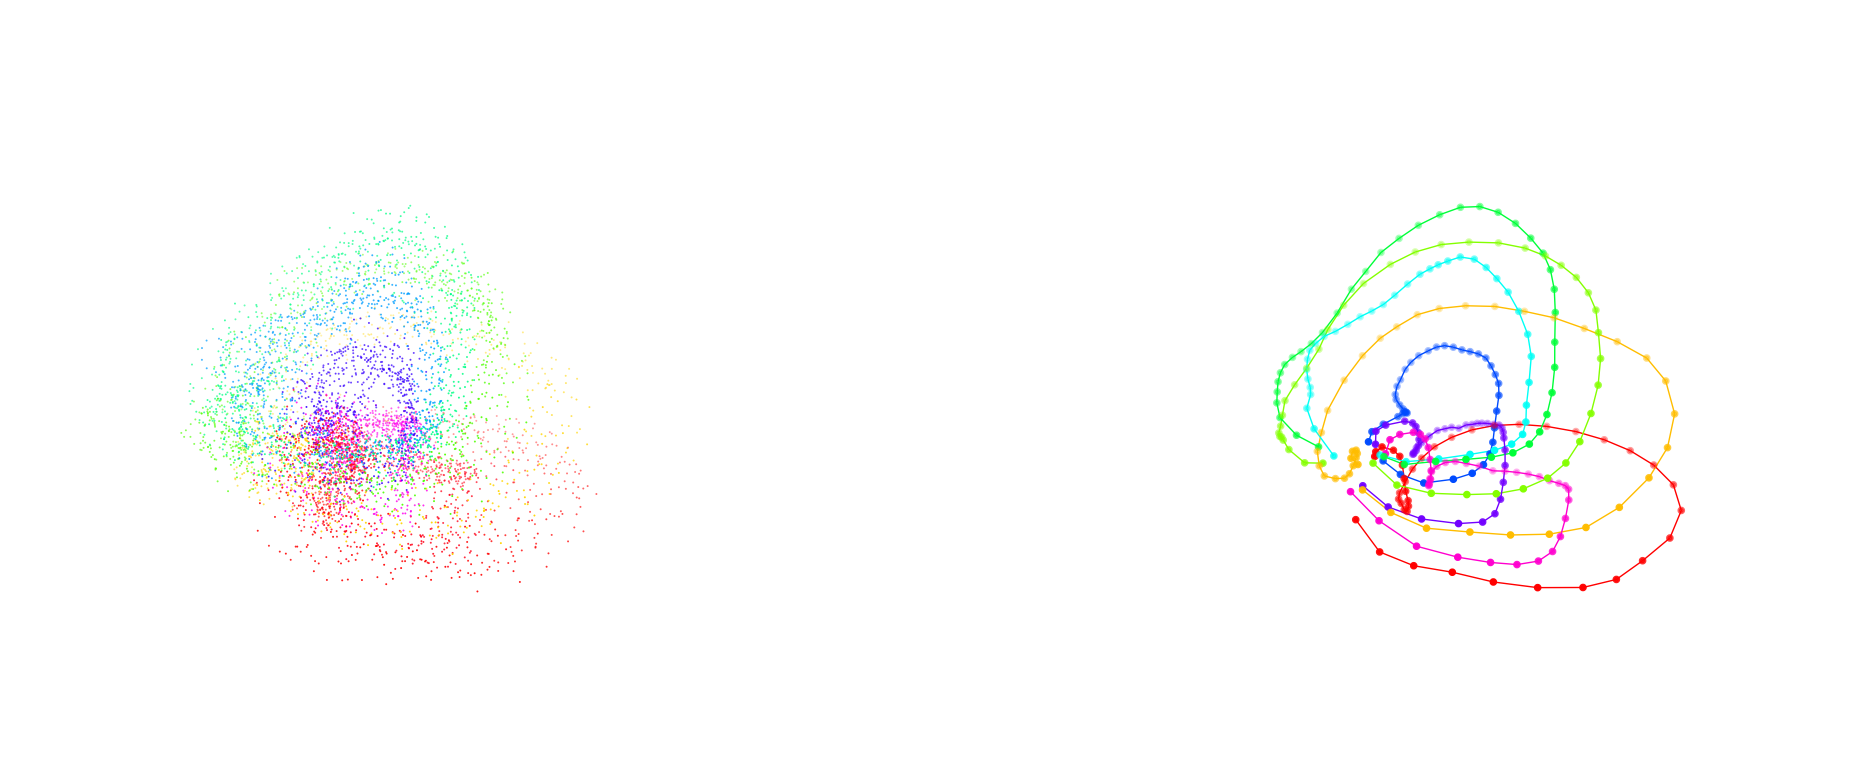

In [ ]:
plot_embedding(emb_pivae_test, dir_test)

3. **Velocity Decoding**  
   Linear regression explains some variance in hand velocity, but performance is weaker than NER and CEBRA.  

4. **Direction Classification**  
   Logistic regression achieves moderate accuracy, lower than both NER and CEBRA.  

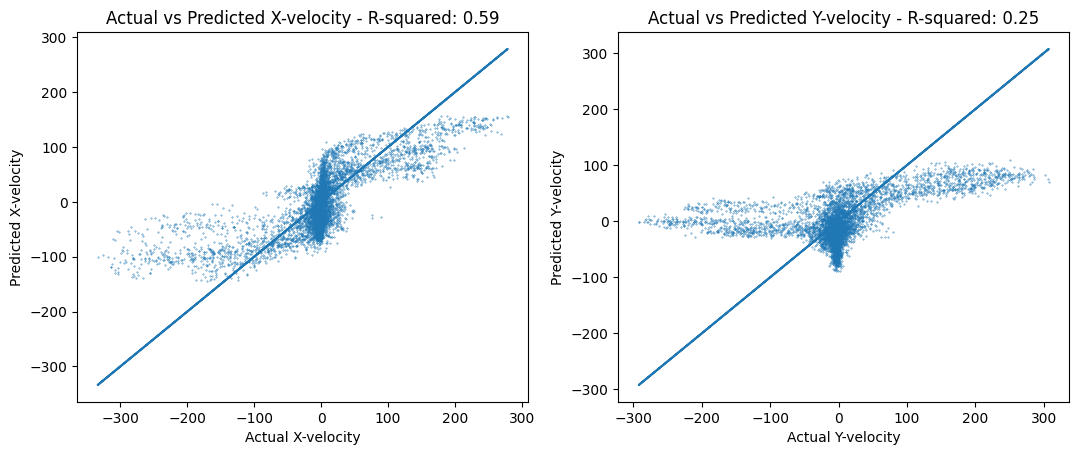

In [ ]:
vel_pred, dir_pred = decode(emb_pivae_train, emb_pivae_test, vel_train, dir_train)

plot_velocity(vel_test, vel_pred)

5. **Position Reconstruction**  
   Predicted positions follow the overall trajectory but with noticeable drift from the ground truth.  

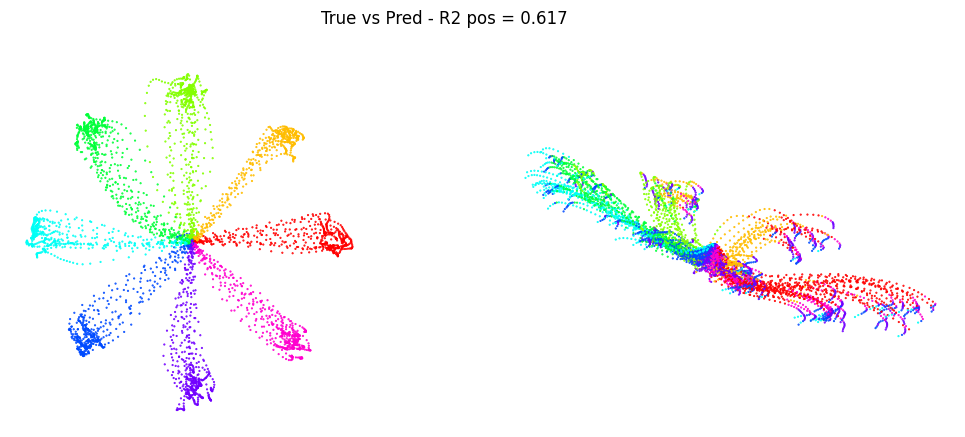

In [ ]:
pos_test = calculate_locations(vel_test)
pos_pred = calculate_locations(vel_pred)

plot_position(pos_test, pos_pred, dir_test, dir_pred)

## UMAP

We next apply **UMAP** (Uniform Manifold Approximation and Projection), a nonlinear dimensionality reduction technique.  
Unlike NER, CEBRA, or pi-VAE, UMAP is **unsupervised** and does not involve training a neural network.

**UMAP Model**

We configure UMAP with:
- `n_neighbors = 68`: controls the balance between local and global structure.  
- `min_dist = 0.2475`: controls how tightly points are clustered.  
- `n_components = 3`: embedding dimension.  
- `metric = 'euclidean'`: distance metric for neighborhood calculations.  

These hyperparameters were chosen to match the paper’s setup.

In [ ]:
import umap

umap_model = umap.UMAP(n_neighbors=68, min_dist=0.2475, n_components=emb_dim, random_state=None, metric='euclidean')

emb_umap_train = umap_model.fit_transform(neural_train)
emb_umap_test = umap_model.transform(neural_test)

**Embedding and Analysis**

- `fit_transform`: computes embeddings for the training neural activity.  
- `transform`: projects test neural activity into the learned manifold.  
- The resulting embeddings are evaluated in the same way as other methods:  
  - Visualization  
  - Velocity decoding  
  - Position reconstruction  
  - Direction classification

1. **Embedding Visualization**  
   UMAP separates movement directions to some extent, but the structure is **less clear** than with NER or CEBRA.  

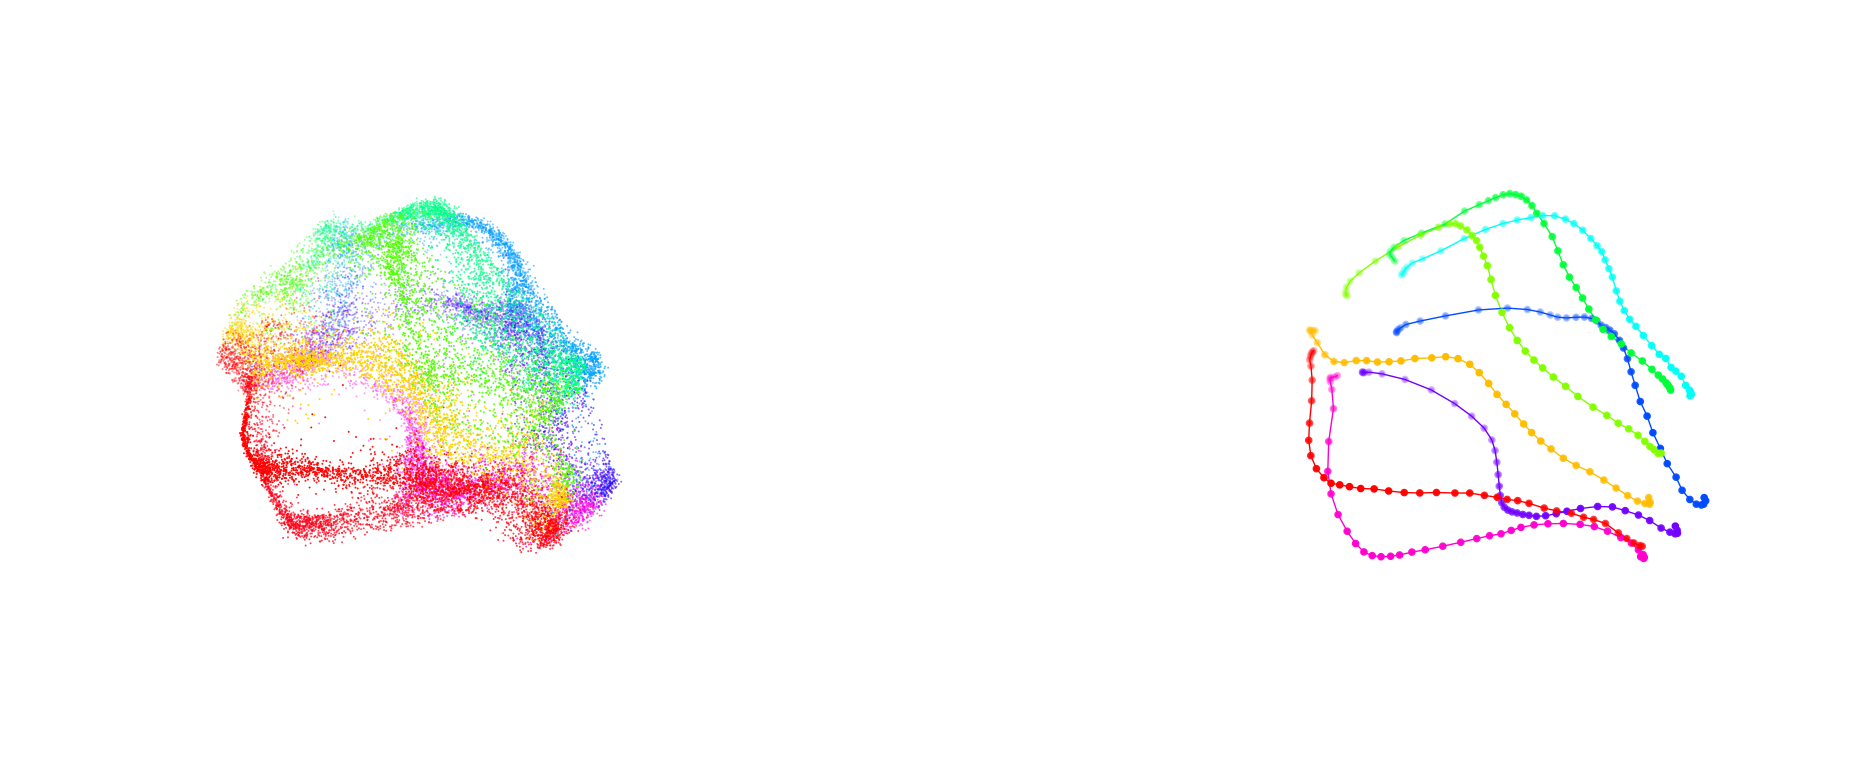

In [ ]:
plot_embedding(emb_umap_test, dir_test)

2. **Velocity Decoding**  
   Linear regression explains only a modest portion of variance.  


3. **Direction Classification**  
   Accuracy is moderate, reflecting UMAP's unsupervised nature.  

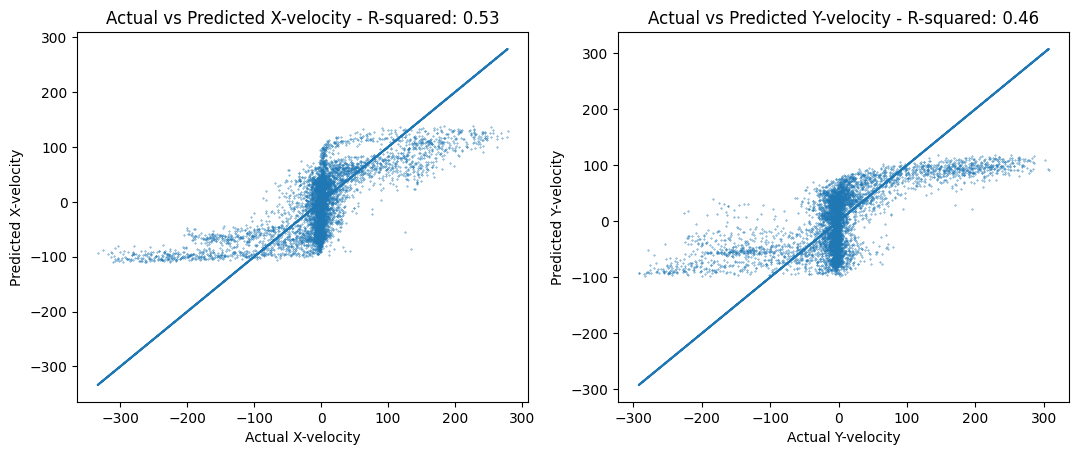

In [ ]:
vel_pred, dir_pred = decode(emb_umap_train, emb_umap_test, vel_train, dir_train)

plot_velocity(vel_test, vel_pred)

4. **Position Reconstruction**  
   Reconstructed trajectories capture general trends but lack fine detail.  

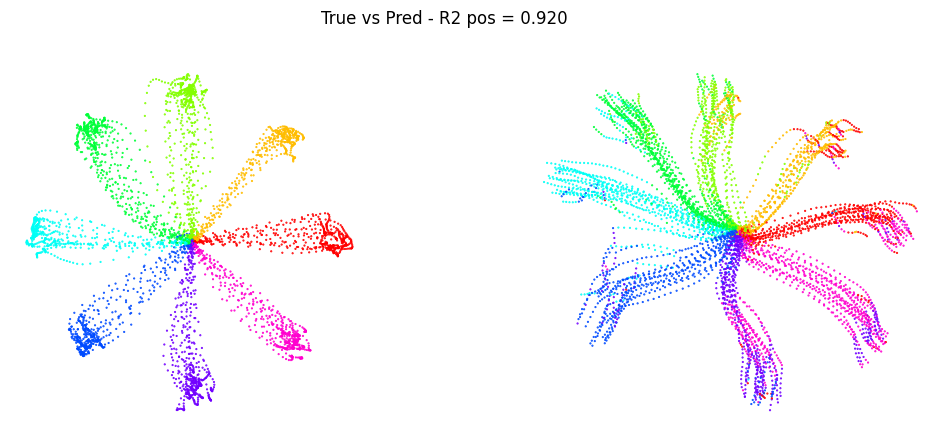

In [ ]:
pos_test = calculate_locations(vel_test)
pos_pred = calculate_locations(vel_pred)

plot_position(pos_test, pos_pred, dir_test, dir_pred)

## PCA

We also evaluate **Principal Component Analysis (PCA)**, a classic linear dimensionality reduction method.  
PCA projects neural activity into a lower-dimensional space by maximizing variance, without using labels.

**PCA Model**

- `n_components = 3`: we reduce neural activity to a 3D latent space.  
- `fit_transform`: learns principal components from training data.  
- `transform`: projects test data into the learned components.  


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=emb_dim)
emb_pca_train = pca.fit_transform(neural_train)
emb_pca_test = pca.transform(neural_test)

**Embedding and Analysis**

The resulting embeddings are analyzed using the same pipeline as before:
- Embedding visualization  
- Velocity decoding with linear regression  
- Position reconstruction  
- Direction classification  

1. **Embedding Visualization**  
   The embeddings show limited separation between movement directions, often overlapping in space.  

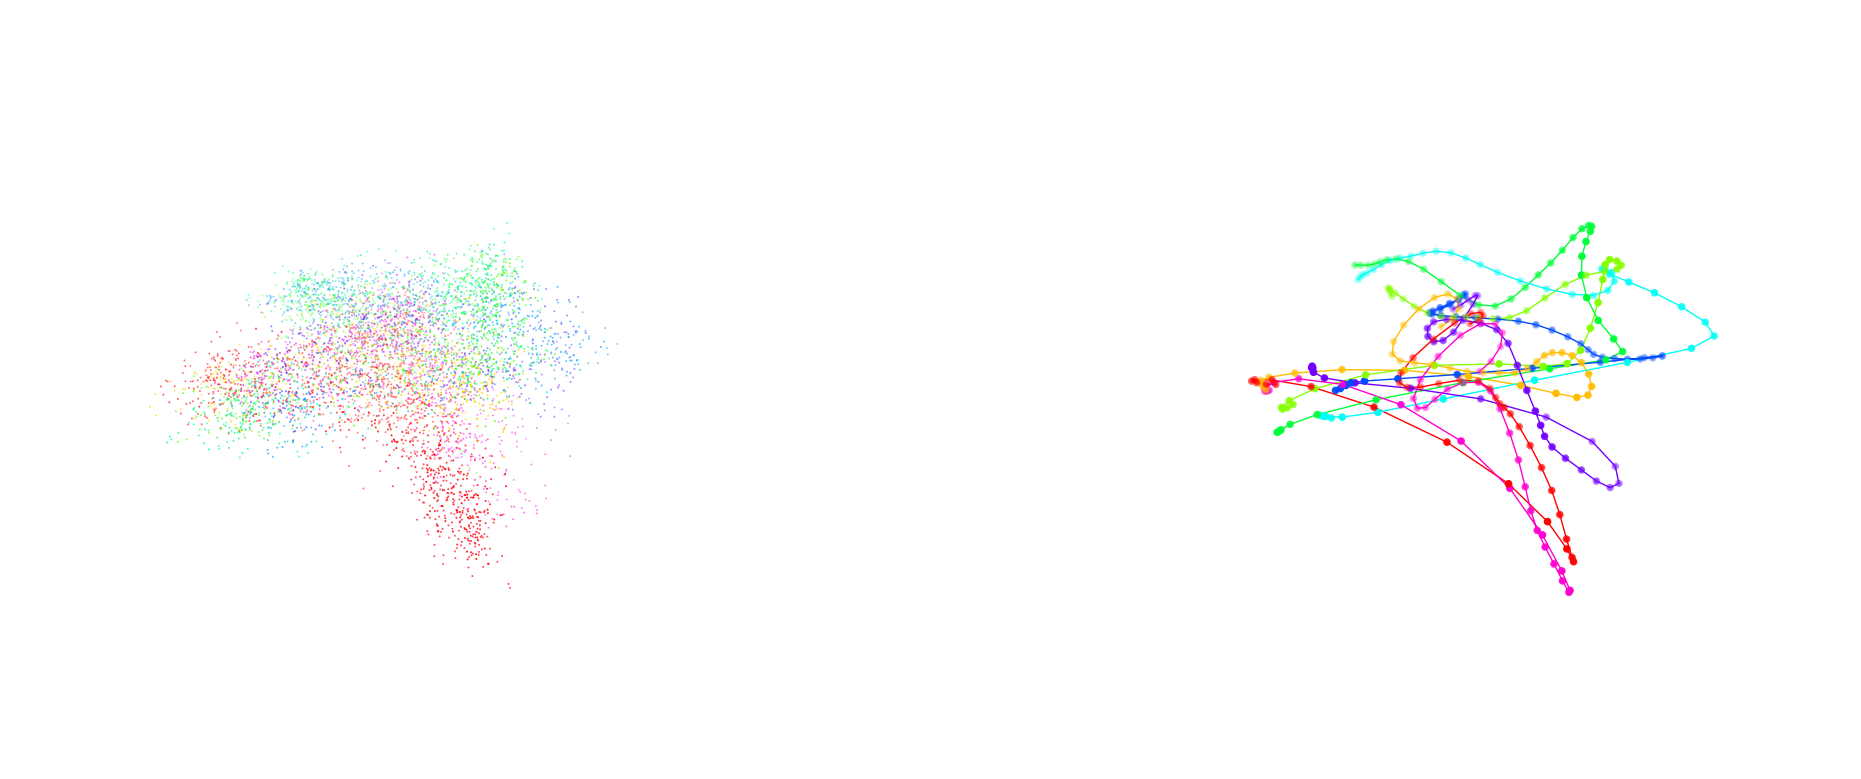

In [ ]:
plot_embedding(emb_pca_test, dir_test)

2. **Velocity Decoding**  
   Decoding performance is weak, as PCA is not optimized for capturing behaviorally relevant signals.  


3. **Direction Classification**  
   Accuracy is low compared to all other methods.

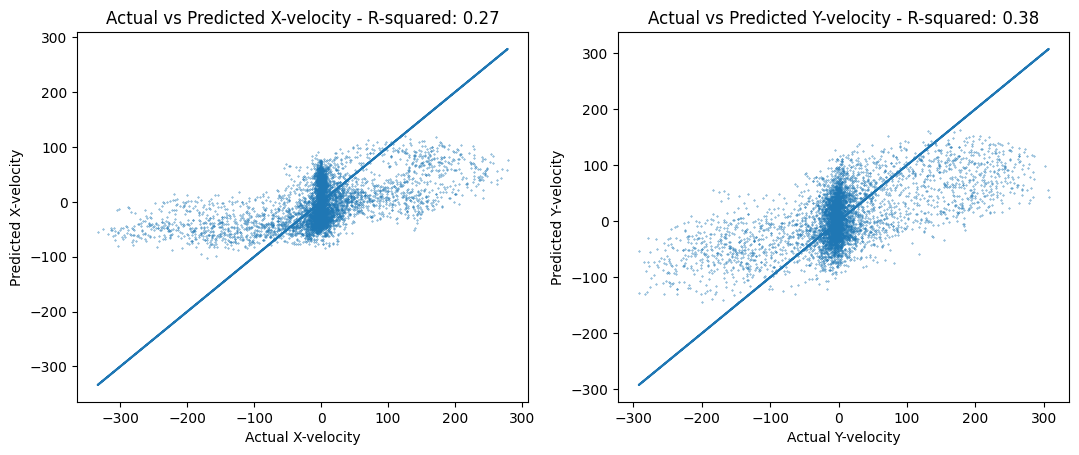

In [ ]:
vel_pred, dir_pred = decode(emb_pca_train, emb_pca_test, vel_train, dir_train)

plot_velocity(vel_test, vel_pred)

4. **Position Reconstruction**  
   Predicted trajectories drift significantly from ground truth.  

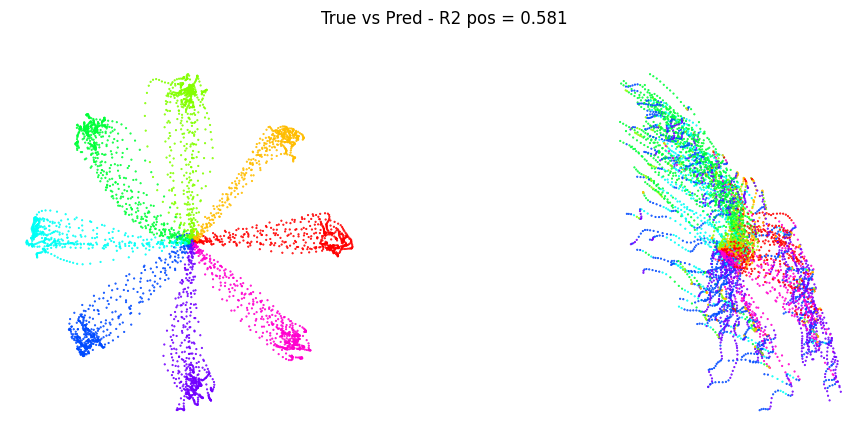

In [ ]:
pos_test = calculate_locations(vel_test)
pos_pred = calculate_locations(vel_pred)

plot_position(pos_test, pos_pred, dir_test, dir_pred)

## dPCA

We also evaluate **demixed Principal Component Analysis (dPCA)**, a dimensionality reduction method designed specifically for neural population data.  
Unlike PCA, dPCA separates neural variability into **task-related** and **time-related** components.

In [ ]:
pip install dpca

**Trial Balancing**

Because dPCA requires balanced conditions across stimuli:
- `get_min_trials_per_angle` finds the minimum number of trials available across all 8 directions.  
- `build_balanced_trial_tensor` constructs a 4D tensor of neural responses with equal trial counts per direction.  
This ensures that each condition is represented fairly.

In [ ]:
def get_min_trials_per_angle(neural, direction):
    stimuli_trials = np.zeros(N_angles)
    for i in range(N_angles):
        direction_trial = (direction // 45 == i)
        trial_dur_neuron = neural[direction_trial, :].reshape(-1, dur, N_neurons)
        stimuli_trials[i] = trial_dur_neuron.shape[0]
    return int(min(stimuli_trials))

def build_balanced_trial_tensor(neural, direction):
    min_trials = get_min_trials_per_angle(neural, direction)
    rates_trial = []
    for i in range(N_angles):
        direction_trial = (direction // 45 == i)
        trial_dur_neuron = neural[direction_trial, :].reshape(-1, dur, N_neurons)
        trial_single = trial_dur_neuron[:min_trials, :, :]
        rates_trial.append(trial_single)
    rate_stack_avg = np.stack(rates_trial, axis=-1)  # (trials, bin, neurons, stimuli)
    trialR = np.transpose(rate_stack_avg, (0, 2, 3, 1))  # (trials, neurons, stimuli, bin)
    return trialR

trialR_train = build_balanced_trial_tensor(neural_train, dir_train)
trialR_test = build_balanced_trial_tensor(neural_test, dir_test)

**Averaging and Centering**

`average_and_center_trials` averages neural activity across trials and removes the overall mean response.  
This centers the data, isolating variance that depends on **stimulus (direction)** and **time**.

In [ ]:
def average_and_center_trials(trialR):
    R = np.mean(trialR, axis=0)  # average over trials
    R_temp = R.reshape((N_neurons, -1))
    R -= np.mean(R_temp, axis=1)[:, None, None]
    return R

R_train = average_and_center_trials(trialR_train)
R_test = average_and_center_trials(trialR_test)

**Applying dPCA**

We fit a dPCA model with:
- `labels='st'`: separate variance into **stimulus (s)**, **time (t)**, and their interaction (st).  
- `n_components=3`: reduce to a 3D latent space.  
- `regularizer='auto'`: automatic regularization to avoid overfitting.  

We specifically extract the **stimulus-related components** (`'s'`) for visualization and decoding.

In [ ]:
from dPCA import dPCA

dpca = dPCA.dPCA(labels='st', regularizer='auto', n_components=emb_dim)
dpca.protect = ['t']

# R =      3D(            neurons, stimuli, bin)
# trialR = 4D(10trials,   neurons, stimuli, bin)
# Z['s']=Z['t']=Z['st'] (components, stimuli, bin)

emb_dpca_train = dpca.fit_transform(R_train, trialR_train)['s']
emb_dpca_test = dpca.transform(R_test)['s']

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.003388200529767837
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


**Embedding Visualization**

The resulting trajectories are plotted in 3D:  
- Each color corresponds to a different movement direction.  
- Lines trace the temporal evolution of neural activity within each direction.  

dPCA produces **clear separation by direction**, though trajectories overlap more than in NER.

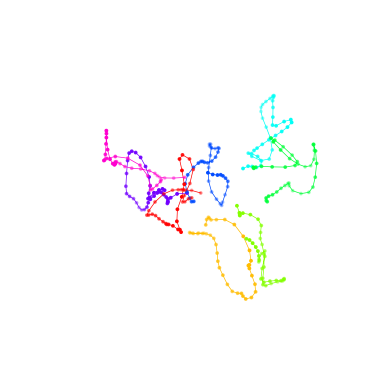

In [ ]:
ax = plt.subplot(projection='3d')

for i in range(N_angles):
    ax.scatter(emb_dpca_test[0, i, :], emb_dpca_test[1, i, :], emb_dpca_test[2, i, :], color=plt.cm.hsv(1 / 8 * i), s=3)
    ax.plot(emb_dpca_test[0, i, :], emb_dpca_test[1, i, :], emb_dpca_test[2, i, :], color=plt.cm.hsv(1 / 8 * i), linewidth=0.5)

ax.set_axis_off()

## Self Decode

To fairly evaluate all embedding methods (NER, CEBRA, pi-VAE, UMAP, and PCA),  
we perform a **self-decoding analysis**.  
The idea is to test how well each embedding preserves task-relevant information,  
by training simple decoders on top of the embeddings and measuring their accuracy.

**Self-Decode Function**

The `self_decode` function loads pre-computed embeddings and evaluates decoding performance.  
Two types of decoders are tested:

- **Linear models** (Linear Regression + Logistic Regression)  
- **Nonlinear models** (k-Nearest Neighbors with hyperparameter search)  

We decode three behavioral variables:
1. **Velocity** (continuous X/Y components, regression)  
2. **Position** (integrated velocity, regression)  
3. **Direction** (discrete labels, classification)  

**Evaluation Metrics**

For each embedding model, we compute:
- **$R^2$ score for velocity** → how well embeddings capture instantaneous movement speed.  
- **$R^2$ score for position** → how well cumulative trajectories match ground truth.  
- **Classification accuracy for direction** → the percentage of correct angle predictions.  
- **Accuracy over time** → classification accuracy aligned to the go cue, revealing temporal dynamics.  

In [ ]:
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

def self_decode(file_path1, decoder):
    Monkey_A = np.load(file_path1)
    X = Monkey_A['cebra_veldir_train']
    y = Monkey_A['continuous_index_train'][:, 0:2]
    y_C = Monkey_A['continuous_index_train'][:, 2]

    if decoder == 'kNN':
        reg = GridSearchCV(KNeighborsRegressor(), {'n_neighbors': [2,4,8,16,32,64,128,256,512,1024]}).fit(X, y)
        cls = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': [2,4,8,16,32,64,128,256,512,1024]}).fit(X, y_C)
    else:
        reg = LinearRegression().fit(X, y)
        cls = LogisticRegression(max_iter=500, solver='lbfgs').fit(X, y_C)

    X = Monkey_A['cebra_veldir_test']
    y = Monkey_A['continuous_index_test'][:,0:2]
    y_C = Monkey_A['continuous_index_test'][:, 2]

    pred_vel_test = reg.predict(X)
    test_trial_A = int(y.shape[0]/dur)
    velocity_reshaped = y.reshape(test_trial_A, dur, 2)
    locations = np.cumsum(velocity_reshaped, axis=1)
    truth_XY = locations.reshape(test_trial_A*dur, 2)
    velocity_reshaped = pred_vel_test.reshape(test_trial_A, dur, 2)
    locations = np.cumsum(velocity_reshaped, axis=1)
    pred_XY = locations.reshape(test_trial_A*dur, 2)

    posi_test_r2 = r2_score(truth_XY, pred_XY)
    vel_test_r2 = r2_score(pred_vel_test, y) ## default is "uniform_average"

    pred_dir_test = cls.predict(X)
    pred_dir_matches = pred_dir_test == y_C
    pred_dir_test_acc = 100*np.sum(pred_dir_matches)/test_trial_A/dur
    differences = 45*abs(pred_dir_test - y_C)
    angle_diffs = np.where(differences > 180, 360 - differences, differences)
    dir_test_r2 = r2_score(pred_dir_test, y_C)

    pred_dir_acc = np.zeros((dur, test_trial_A))
    for i in range(test_trial_A):
        t_pred = pred_dir_test[dur*(i):dur*(i+1)]
        t_truth = y_C[dur*(i):dur*(i+1)]
        pred_dir_acc[np.where(t_pred == t_truth), i] = 1
    acc_time = 100*np.sum(pred_dir_acc, axis=1)/test_trial_A
    pred_max_acc = np.max(acc_time)

    return posi_test_r2, vel_test_r2, pred_max_acc, acc_time

**Plotting Results**

The `plot_self_accuracy` function summarizes decoding results:

1. **Direction accuracy over time** → mean and variability across sessions.  
2. **Velocity decoding performance** → $R^2$ values per recording date.  
3. **Position decoding performance** → $R^2$ values per recording date.  

This allows for both **within-session** (temporal) and **across-session** (date-level) comparisons.

In [ ]:
def plot_self_accuracy(model, acc_time_2D, vel_R_2D, pos_R_2D, date_subjects):
    plt.subplot(1, 3, 1)
    time_bins = np.arange(0, dur)
    mean_values = np.mean(acc_time_2D, axis=0)
    sem_values = np.std(acc_time_2D, axis=0) / 1
    peak = np.round(np.max(mean_values), 1)
    plt.plot(time_bins, mean_values, linewidth=2, label=f'{model} {peak}%')
    plt.fill_between(time_bins, mean_values - sem_values, mean_values + sem_values, alpha=0.075)
    plt.ylim(0, 100)
    plt.xlabel('Time from go cue (ms)')
    plt.ylabel('Direction classification accuracy (%)')
    plt.legend()

    plt.subplot(1, 3, 2)
    T_avg = np.round(np.median(vel_R_2D), 1)
    plt.plot(vel_R_2D, marker='o', label=f'{model} {T_avg}')
    plt.ylim(0, 1)
    plt.xlabel('Recording date (YYMMDD)')
    plt.ylabel('Explained variance')
    plt.title('Velocities: Chewie 2016&2015')
    plt.xticks(ticks=np.arange(len(vel_R_2D)), labels=date_subjects, rotation=90)
    plt.legend()

    plt.subplot(1, 3, 3)
    T_avg = np.round(np.median(pos_R_2D), 1)
    plt.plot(pos_R_2D, marker='o', label=f'{model} {T_avg}')
    plt.ylim(0, 1)
    plt.xlabel('Recording date (YYMMDD)')
    plt.ylabel('Explained variance')
    plt.title('Positions:  Chewie 2016&2015')
    plt.xticks(ticks=np.arange(len(pos_R_2D)), labels=date_subjects, rotation=90)
    plt.legend()

**Across-Model Comparison**

The `self_decode_across_models` function runs self-decoding for each embedding model (NER, CEBRA, pi-VAE, UMAP, UMAP+labels).  
We repeat the analysis for:
- **Linear decoders** (baseline, interpretable performance)  
- **kNN decoders** (nonlinear benchmark with flexible decision boundaries).  

Together, these results reveal the **relative strengths and weaknesses of each embedding approach**.

In [ ]:
import os

def self_decode_across_models(decoder):
    plt.figure(figsize=(3 * fig_width, fig_height))

    for model in ['NER', 'Cebra', 'piVAE', 'UMAP', 'UMAP_label']:
        files_directory = os.path.join(directory, f'NER/data_NER/M1 4+6+6/{model}_Chewie')
        files = [os.path.join(files_directory, f) for f in os.listdir(files_directory)]
        date_subjects = [f[7:13] for f in os.listdir(files_directory)]

        n = len(files)
        pos_R_2D, vel_R_2D, peak_acc_2D, acc_time_2D = np.empty(n), np.empty(n), np.empty(n), np.empty((n, dur))
        for i, file in enumerate(files):
            pos_R_2D[i], vel_R_2D[i], peak_acc_2D[i], acc_time_2D[i] = self_decode(file, decoder)

        plot_self_accuracy(model, acc_time_2D, vel_R_2D, pos_R_2D, date_subjects)

    plt.suptitle(decoder, fontsize=16)
    plt.show()

**Results**

- **NER** achieves the highest decoding performance across velocity, position, and direction.  
- **CEBRA** performs slightly below NER but still outperforms pi-VAE, UMAP, and PCA.  
- **pi-VAE** captures structure but underperforms compared to contrastive methods.  
- **UMAP / PCA** embeddings are less predictive, reflecting their unsupervised nature.  

This confirms that **task-informed contrastive embeddings (NER/CEBRA)**  
provide the most behaviorally relevant representations of neural population activity.

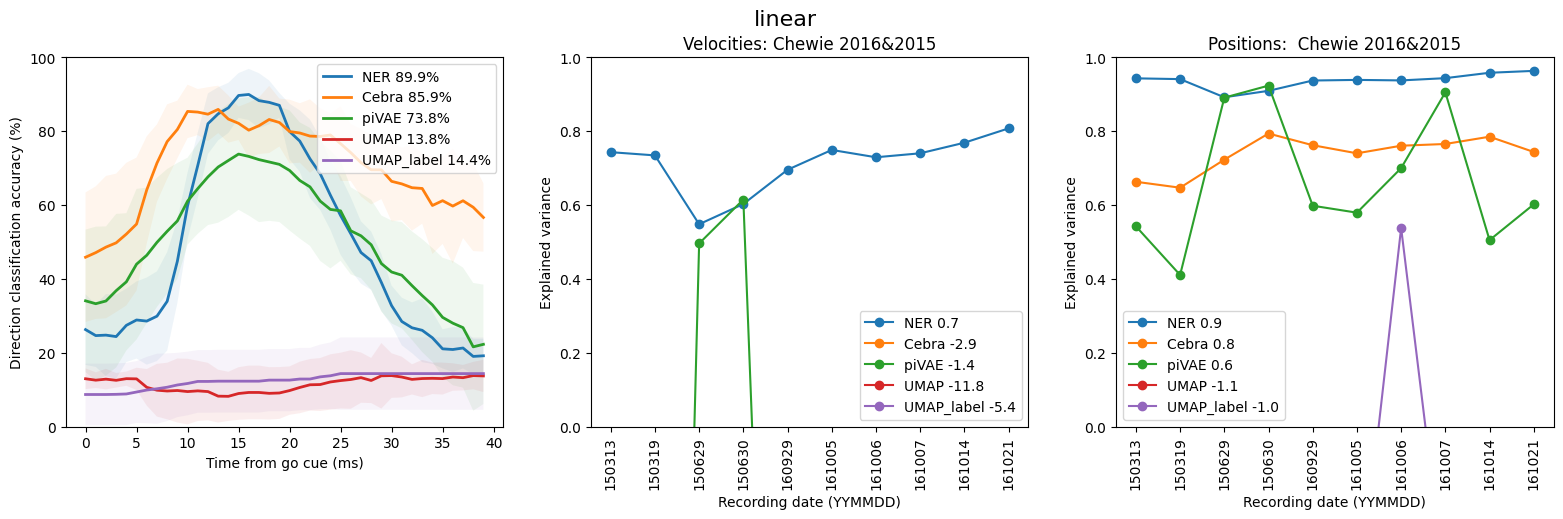

In [ ]:
self_decode_across_models('linear')

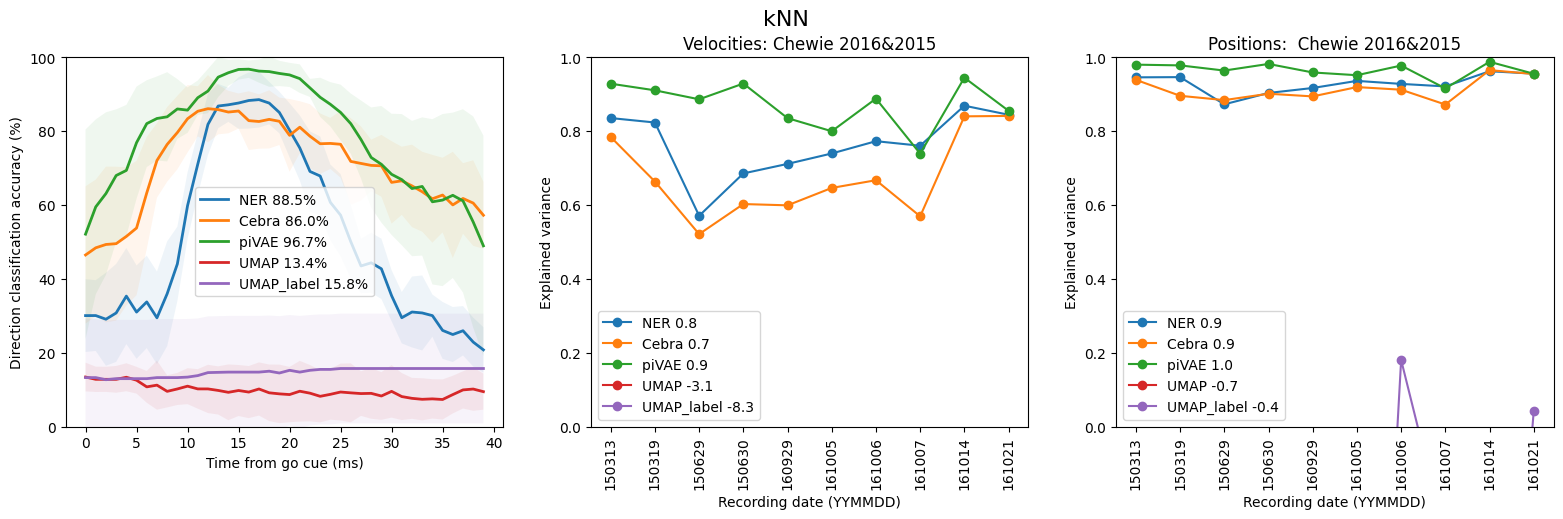

In [ ]:
self_decode_across_models('kNN')

## Cross-Decoding

Self-decoding shows that embeddings preserve task information **within a session**,  
but we also need to test whether embeddings are **consistent across different sessions** (or days).  

**Cross-decoding** evaluates this by:
1. Training a decoder on embeddings from session A,  
2. Testing it on embeddings from session B.  

If embeddings from different days are aligned in the same latent space,  
then decoding across sessions should remain accurate.

**Alignment of Embeddings Across Sessions**

Since embeddings from different days may be arbitrarily rotated or reflected in latent space,  
we first align them using **orthogonal Procrustes analysis**.

For each movement direction $a \in \{0, 1, \dots, N_\text{angles}-1\}$:
- Compute the trial-averaged embeddings $\bar{Z}_A^a \in \mathbb{R}^{T \times d}$ and $\bar{Z}_B^a \in \mathbb{R}^{T \times d}$  
  (where $T$ = duration, $d$ = embedding dimension).  
- Solve the orthogonal Procrustes problem:

$$
R_a = \arg\min_{R \in O(d)} \; \| \bar{Z}_A^a R - \bar{Z}_B^a \|_F
$$

subject to $R^\top R = I$.

This finds the best rotation/reflection $R_a$ that aligns condition-specific trajectories across sessions.

**Choosing the Best Global Alignment**

After computing $R_a$ for all angles, we need to select a global transformation $R$  
that best matches the overall embedding structures.  

The algorithm:
- Evaluate both **positive-determinant** (rotation) and **negative-determinant** (rotation+reflection) solutions.  
- Select the transformation with determinant closest to $+1$ (for rotation) or $-1$ (for reflection)  
  that minimizes the alignment error:

$$
\text{AlignDiff}(R) = \sum_{i=1}^N \big\| Z_A R - Z_A^\text{aligned} \big\|_1
$$

- The chosen $R$ is applied to all embeddings from session A.

**Cross-Decoding Procedure**

Once session A is aligned to session B:

1. **Train decoders on A-aligned embeddings**  
   - Velocity: Linear Regression or kNN Regressor  
   - Position: obtained by integrating predicted velocities  
   - Direction: Logistic Regression or kNN Classifier  

2. **Test on session B embeddings**  
   - Evaluate velocity $R^2$, position $R^2$, and direction accuracy.  
   - Compute accuracy as a function of time to analyze temporal dynamics.

**Cross-Accuracy Matrices**

The results are summarized as **cross-session accuracy matrices**:

- Rows = training session  
- Columns = testing session  
- Diagonal entries = within-session self-decoding  
- Off-diagonal entries = cross-session decoding  

For each model (NER, CEBRA, pi-VAE), we visualize:
- **Velocity decoding performance ($R^2$)**  
- **Position decoding performance ($R^2$)**  
- **Direction classification peak accuracy (%)**

In [ ]:
from scipy.linalg import orthogonal_procrustes

def get_best_R(R_all, emb_A, emb_A_8angle_align):
    determinants = [np.linalg.det(R_all[:, :, i]) for i in range(R_all.shape[2])]
    positive_dets = [det for det in determinants if det >= 0]
    negative_dets = [det for det in determinants if det < 0]

    if len(positive_dets)>0:
        target_dets = positive_dets
        differences = [abs(abs(det) - 1) for det in target_dets]
        min_index = np.argmin(differences)
        best_R_index_p = determinants.index(positive_dets[min_index])
        best_R_p = R_all[:, :, best_R_index_p]
        emb_A_whole_align_p = np.matmul(emb_A, best_R_p)
        align_diff_p = np.sum(abs(emb_A_whole_align_p-emb_A_8angle_align))
    elif len(positive_dets) == 0:
        align_diff_p = 5000000 ### arbitory value

    if len(negative_dets)>0:
        target_dets = negative_dets
        differences = [abs(abs(det) - 1) for det in target_dets]
        min_index = np.argmin(differences)
        best_R_index_n = determinants.index(negative_dets[min_index])
        best_R_n = R_all[:, :, best_R_index_n]
        emb_A_whole_align_n = np.matmul(emb_A, best_R_n)
        align_diff_n = np.sum(abs(emb_A_whole_align_n-emb_A_8angle_align))
    elif len(negative_dets) == 0:
        align_diff_n = 5000000

    if align_diff_p<align_diff_n:
        best_R = best_R_p
    elif align_diff_p>align_diff_n:
        best_R = best_R_n
    return best_R


def cross_decode(file_path1, file_path2, decoder):
    Monkey_A = np.load(file_path1)
    XYTarget_A = np.concatenate((Monkey_A['continuous_index_train'], Monkey_A['continuous_index_test']), axis=0)
    emb_A = np.concatenate((Monkey_A['cebra_veldir_train'], Monkey_A['cebra_veldir_test']), axis=0)
    if np.max(XYTarget_A[:, 2])>10: ### angles in 0-45-90-...315degrees
        XYTarget_A[:, 2] = XYTarget_A[:, 2]/45

    Monkey_B = np.load(file_path2)
    XYTarget_B = np.concatenate((Monkey_B['continuous_index_train'], Monkey_B['continuous_index_test']), axis=0)
    emb_B = np.concatenate((Monkey_B['cebra_veldir_train'], Monkey_B['cebra_veldir_test']), axis=0)
    if np.max(XYTarget_B[:, 2])>10:
        XYTarget_B[:, 2] = XYTarget_B[:, 2]/45

    train_trial_A = int(Monkey_A['continuous_index_train'].shape[0]/dur)
    test_trial_A = int(Monkey_A['continuous_index_test'].shape[0]/dur)
    train_trial_B = int(Monkey_B['continuous_index_train'].shape[0]/dur)
    test_trial_B = int(Monkey_B['continuous_index_test'].shape[0]/dur)

    R_all = np.zeros((emb_dim, emb_dim, N_angles))
    for a in range(N_angles):
        direction_trial = (XYTarget_A[:, 2] == a)
        trial_avg_A = emb_A[direction_trial, :].reshape(-1,dur,emb_dim).mean(axis=0)
        direction_trial = (XYTarget_B[:, 2] == a)
        trial_avg_B = emb_B[direction_trial, :].reshape(-1,dur,emb_dim).mean(axis=0)
        R, sca = orthogonal_procrustes(trial_avg_A, trial_avg_B) ### both are (dur, 3emb-dim)
        R_all[:,:, a] = R
        det_R = np.linalg.det(R)
    trial_arrays = []
    for i in range(N_angles):
        direction_trial = (XYTarget_A[:, 2] == i)
        trial_A = emb_A[direction_trial, :].reshape(-1,dur,emb_dim)
        trial_A = np.matmul(trial_A, R_all[:,:,i])
        trial_arrays.append((direction_trial, trial_A))
    emb_A_8angle_align = np.empty_like(emb_A)
    for mask, trial_data in trial_arrays: ### loop-through 8 times=angles
        flat_data = trial_data.reshape(-1, emb_dim) ### (n-trials*dur, 3emb-dim)
        emb_A_8angle_align[mask, :] = flat_data

    emb_A_whole_align = np.matmul(emb_A, get_best_R(R_all, emb_A, emb_A_8angle_align))

    continuous_index_train = XYTarget_A[:train_trial_A*dur, :]
    cebra_veldir_train = emb_A_whole_align[:train_trial_A*dur, :] ####***** three choices here *****####
    continuous_index_test_B = XYTarget_B[-test_trial_B*dur:, :]
    cebra_veldir_test_B = emb_B[-test_trial_B*dur:, :]

    X = cebra_veldir_train
    y = continuous_index_train[:, 0:2]
    y_C = continuous_index_train[:, 2]

    if decoder == 'kNN':
        reg = GridSearchCV(KNeighborsRegressor(), {'n_neighbors': [2,4,8,16,32,64,128,256,512,1024]}).fit(X, y)
        cls = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': [2,4,8,16,32,64,128,256,512,1024]}).fit(X, y_C)
    else:
        reg = LinearRegression().fit(X, y)
        cls = LogisticRegression(max_iter=500, solver='lbfgs').fit(X, y_C)

    X = cebra_veldir_test_B
    y = continuous_index_test_B[:, 0:2]
    y_C = continuous_index_test_B[:, 2]

    pred_vel_test = reg.predict(X)
    velocity_reshaped = y.reshape(test_trial_B, dur, 2)
    locations = np.cumsum(velocity_reshaped, axis=1)
    truth_XY = locations.reshape(test_trial_B*dur, 2)

    velocity_reshaped = pred_vel_test.reshape(test_trial_B, dur, 2)
    locations = np.cumsum(velocity_reshaped, axis=1)
    pred_XY = locations.reshape(test_trial_B*dur, 2)

    posi_test_r2 = r2_score(truth_XY, pred_XY)
    vel_test_r2 = r2_score(pred_vel_test, y)

    pred_dir_test = cls.predict(X)
    pred_dir_acc = np.zeros((dur, test_trial_B))
    for i in range(test_trial_B): ## test_trial
        t_pred = pred_dir_test[dur*(i):dur*(i+1)]
        t_truth = y_C[dur*(i):dur*(i+1)]
        pred_dir_acc[np.where(t_pred == t_truth), i] = 1
    acc_time = 100*np.sum(pred_dir_acc, axis=1)/test_trial_B
    pred_max_acc = np.max(acc_time)
    return posi_test_r2, vel_test_r2, pred_max_acc, acc_time

In [ ]:
def plot_cross_accuracy(j, model, vel_R_2D, pos_R_2D, peak_acc_2D, date_subjects):
    for i, Mat_temp in enumerate([vel_R_2D, pos_R_2D, peak_acc_2D]):
        plt.subplot(3, 3, 3 * i + j + 1)

        if i == 2:
            plt.imshow(Mat_temp, vmin=20, vmax=100)
        else:
            plt.imshow(Mat_temp, vmin=0, vmax=1)

        non_diagonal_values = Mat_temp[~np.eye(len(Mat_temp), dtype=bool)]
        if i == 0:
            plt.title(f'{model}\ndia = {np.mean(np.diag(Mat_temp)):.2f}, off-dia = {np.mean(non_diagonal_values):.2f}')
        else:
            plt.title(f'dia = {np.mean(np.diag(Mat_temp)):.2f}, off-dia = {np.mean(non_diagonal_values):.2f}')

        plt.xticks([])
        if j == 0:
            plt.yticks(ticks=np.arange(len(Mat_temp)), labels=date_subjects)

In [ ]:
def cross_decode_across_models(decoder):
    plt.figure(figsize=(3 * fig_height, 3 * fig_height))

    for m, model in enumerate(['NER', 'Cebra', 'piVAE']):

        files_directory = os.path.join(directory, f'NER/data_NER/M1 4+6+6/{model}_Chewie')
        files = [os.path.join(files_directory, f) for f in os.listdir(files_directory)]
        date_subjects = [f[7:13] for f in os.listdir(files_directory)]

        n = len(files)
        pos_R_2D, vel_R_2D, peak_acc_2D, acc_time_2D = np.empty((n, n)), np.empty((n, n)), np.empty((n, n)), np.empty((dur, n * n))

        for i, file1 in enumerate(files):
            for j, file2 in enumerate(files):
                pos_R_2D[i, j], vel_R_2D[i, j], peak_acc_2D[i, j], acc_time_2D[:, i * n + j] = cross_decode(file1, file2, decoder)

        plot_cross_accuracy(m, model, vel_R_2D, pos_R_2D, peak_acc_2D, date_subjects)

    plt.suptitle(decoder, fontsize=16)
    plt.show()

**Results**

- **NER**: Exhibits the strongest cross-decoding performance, with off-diagonal accuracy close to diagonal values.  
  → This means NER embeddings are well-aligned across sessions, capturing a stable neural representation.  
- **CEBRA**: Also shows good cross-decoding, though slightly weaker than NER.  
- **pi-VAE**: Performs less consistently, with cross-session generalization dropping significantly.  

These results highlight that **contrastive representation learning (NER/CEBRA)**  
produces embeddings that are not only predictive but also **consistent across sessions**,  
a critical property for real-world neural decoding applications.

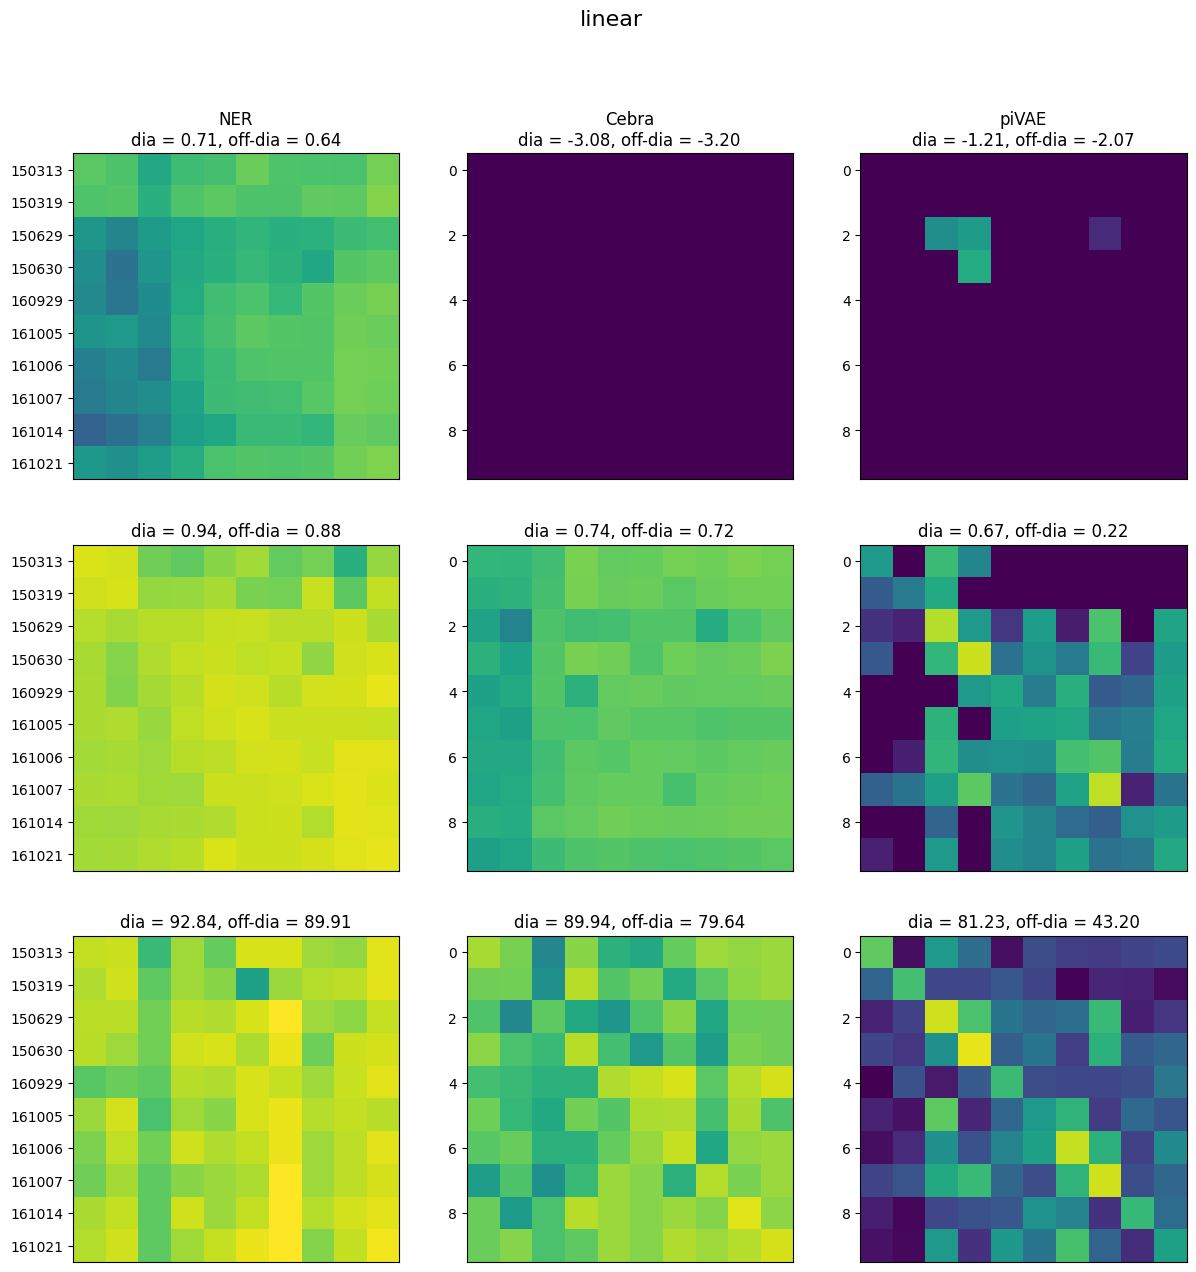

In [ ]:
cross_decode_across_models('linear')

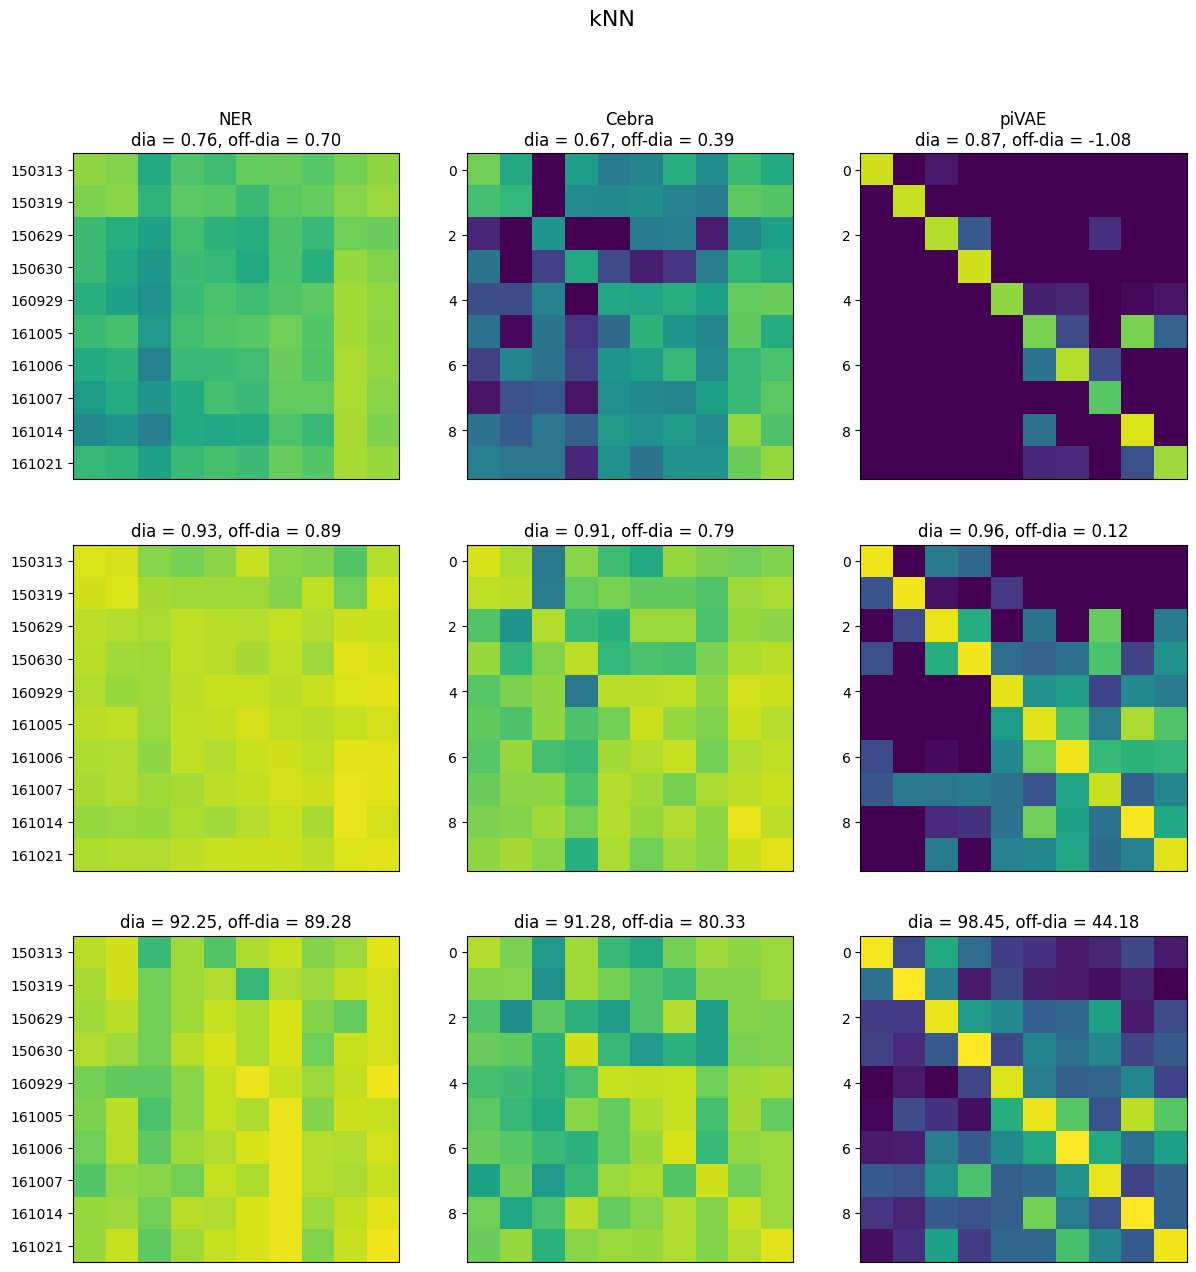

In [ ]:
cross_decode_across_models('kNN')